In [2]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [3]:


!pip install pandas numpy matplotlib seaborn scikit-learn -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.sparse import csr_matrix, lil_matrix
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print(" Environment setup complete - Using lightweight libraries only")

 Environment setup complete - Using lightweight libraries only



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\VICTUS\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [4]:
def load_data():
    """Load and prepare data"""
    print(" Loading data")
    
    # Load ratings 
    ratings_path = r"D:\irs project\Section 1 Dataset\ml-25m\ratings.csv"
    ratings = pd.read_csv(ratings_path)
    
    #  load movies data
    try:
        movies_path = r"D:\irs project\Section 1 Dataset\ml-25m\ratings.csv"
        movies = pd.read_csv(movies_path)
        print(f" Loaded {len(movies)} movies")
    except:
        print(" movies.csv not found, working with ratings only")
        movies = None
    
    print(f" Loaded {len(ratings)} ratings from {ratings['userId'].nunique()} users")
    print(f"   Unique movies rated: {ratings['movieId'].nunique()}")
    
    return ratings, movies

# Load data
ratings, movies = load_data()

# Show data sample
print("\nData sample:")
print(ratings.head())
if movies is not None:
    print(movies.head())

 Loading data
 Loaded 25000095 movies
 Loaded 25000095 ratings from 162541 users
   Unique movies rated: 59047

Data sample:
   userId  movieId  rating   timestamp
0       1      296     5.0  1147880044
1       1      306     3.5  1147868817
2       1      307     5.0  1147868828
3       1      665     5.0  1147878820
4       1      899     3.5  1147868510
   userId  movieId  rating   timestamp
0       1      296     5.0  1147880044
1       1      306     3.5  1147868817
2       1      307     5.0  1147868828
3       1      665     5.0  1147878820
4       1      899     3.5  1147868510



 Data Analysis:


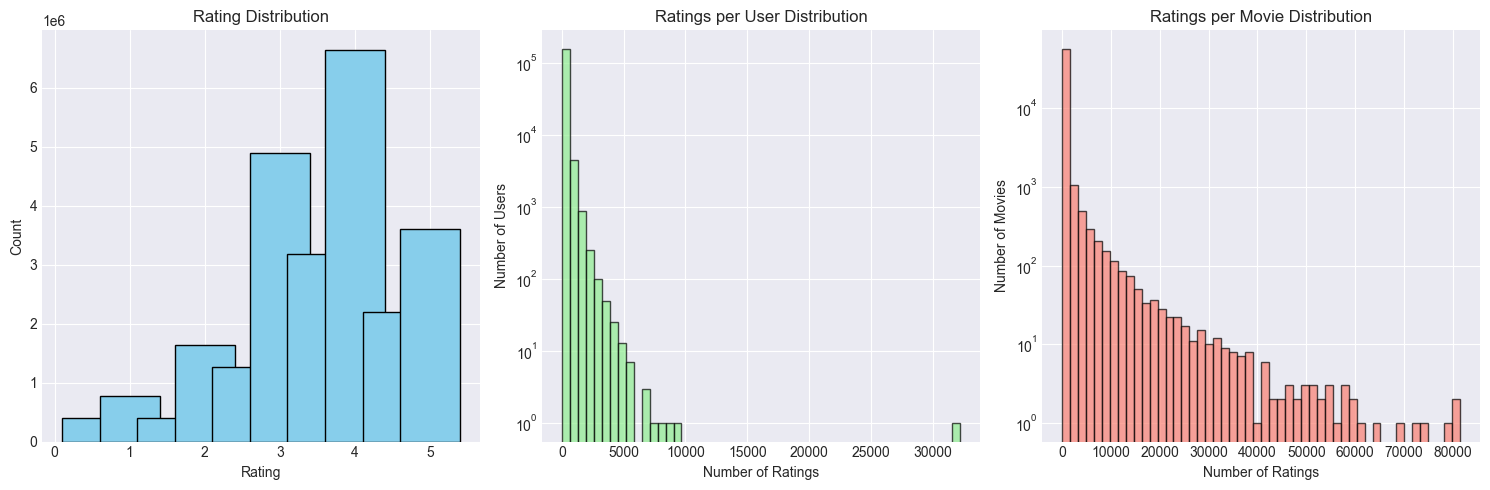


 Key Statistics:
Average rating: 3.53
Rating std dev: 1.06
Number of users: 162541
Number of movies: 59047
Sparsity: 0.9974
   (Closer to 1 means more sparse data)


In [5]:
#  Data Exploration
def explore_data(ratings, movies):
    """Explore and analyze the dataset"""
    
    print("\n Data Analysis:")
    
    # 1. Rating distribution
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    rating_counts = ratings['rating'].value_counts().sort_index()
    plt.bar(rating_counts.index, rating_counts.values, color='skyblue', edgecolor='black')
    plt.title('Rating Distribution')
    plt.xlabel('Rating')
    plt.ylabel('Count')
    
    # 2. Ratings per user
    plt.subplot(1, 3, 2)
    user_rating_counts = ratings.groupby('userId').size()
    plt.hist(user_rating_counts, bins=50, color='lightgreen', edgecolor='black', alpha=0.7)
    plt.title('Ratings per User Distribution')
    plt.xlabel('Number of Ratings')
    plt.ylabel('Number of Users')
    plt.yscale('log')
    
    # 3. Ratings per movie
    plt.subplot(1, 3, 3)
    movie_rating_counts = ratings.groupby('movieId').size()
    plt.hist(movie_rating_counts, bins=50, color='salmon', edgecolor='black', alpha=0.7)
    plt.title('Ratings per Movie Distribution')
    plt.xlabel('Number of Ratings')
    plt.ylabel('Number of Movies')
    plt.yscale('log')
    
    plt.tight_layout()
    plt.show()
    
    # 4. Key statistics
    print("\n Key Statistics:")
    print(f"Average rating: {ratings['rating'].mean():.2f}")
    print(f"Rating std dev: {ratings['rating'].std():.2f}")
    print(f"Number of users: {ratings['userId'].nunique()}")
    print(f"Number of movies: {ratings['movieId'].nunique()}")
    
    # 5. Sparsity calculation
    num_users = ratings['userId'].nunique()
    num_movies = ratings['movieId'].nunique()
    num_ratings = len(ratings)
    sparsity = 1 - (num_ratings / (num_users * num_movies))
    print(f"Sparsity: {sparsity:.4f}")
    print(f"   (Closer to 1 means more sparse data)")
    
    return user_rating_counts, movie_rating_counts

# Run exploration
user_counts, movie_counts = explore_data(ratings, movies)


 User Categorization:
Cold-start users: 160762
Medium activity users: 1649
Active users: 129
Power users: 1


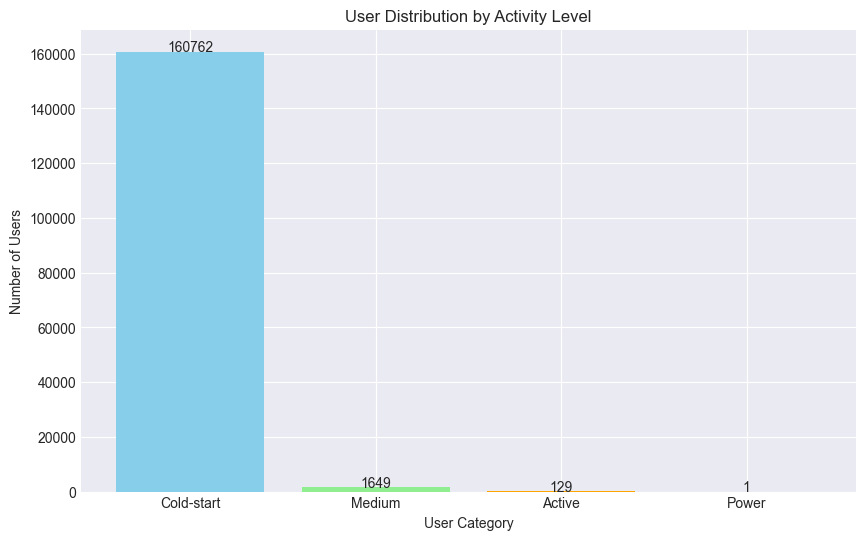

In [6]:
#  User Categorization
def categorize_users(ratings, total_items):
    """Categorize users based on their activity level"""
    
    user_rating_counts = ratings.groupby('userId')['movieId'].nunique()
    
    # Define thresholds
    cold_threshold = 0.02 * total_items      # Less than 2%
    medium_threshold = 0.05 * total_items    # Between 2-5%
    active_threshold = 0.20 * total_items    # Between 5-20%
    
    # Categorize
    cold_users = user_rating_counts[user_rating_counts <= cold_threshold]
    medium_users = user_rating_counts[
        (user_rating_counts > cold_threshold) & 
        (user_rating_counts <= medium_threshold)
    ]
    active_users = user_rating_counts[
        (user_rating_counts > medium_threshold) & 
        (user_rating_counts <= active_threshold)
    ]
    power_users = user_rating_counts[user_rating_counts > active_threshold]
    
    print("\n User Categorization:")
    print(f"Cold-start users: {len(cold_users)}")
    print(f"Medium activity users: {len(medium_users)}")
    print(f"Active users: {len(active_users)}")
    print(f"Power users: {len(power_users)}")
    
    # Visualize distribution
    categories = ['Cold-start', 'Medium', 'Active', 'Power']
    counts = [len(cold_users), len(medium_users), len(active_users), len(power_users)]
    
    plt.figure(figsize=(10, 6))
    plt.bar(categories, counts, color=['skyblue', 'lightgreen', 'orange', 'red'])
    plt.title('User Distribution by Activity Level')
    plt.xlabel('User Category')
    plt.ylabel('Number of Users')
    
    for i, count in enumerate(counts):
        plt.text(i, count + 50, str(count), ha='center')
    
    plt.show()
    
    return {
        'cold_users': cold_users.index.tolist(),
        'medium_users': medium_users.index.tolist(),
        'active_users': active_users.index.tolist(),
        'power_users': power_users.index.tolist()
    }

# Apply categorization
total_items = ratings['movieId'].nunique()
user_categories = categorize_users(ratings, total_items)

In [8]:
#  Data Preparation
def prepare_data(ratings, test_size=0.2, random_state=42):
    """Prepare data for training and testing"""
    
    print("\n Preparing data...")
    
    # 1. Split data
    train_data, test_data = train_test_split(
        ratings, 
        test_size=test_size, 
        random_state=random_state,
        stratify=ratings['userId']  # Preserve user distribution
    )
    
    print(f"Training data: {len(train_data)} ratings")
    print(f"Test data: {len(test_data)} ratings")
    
    # 2. Create User-Item matrix for training
    user_mapper = {user: idx for idx, user in enumerate(train_data['userId'].unique())}
    movie_mapper = {movie: idx for idx, movie in enumerate(train_data['movieId'].unique())}
    
    n_users = len(user_mapper)
    n_movies = len(movie_mapper)
    
    # Create sparse matrix
    train_matrix = lil_matrix((n_users, n_movies))
    
    for _, row in train_data.iterrows():
        user_idx = user_mapper[row['userId']]
        movie_idx = movie_mapper[row['movieId']]
        train_matrix[user_idx, movie_idx] = row['rating']
    
    train_matrix = train_matrix.tocsr()
    
    print(f"Training matrix shape: {train_matrix.shape} (users × movies)")
    print(f"Sparsity: {train_matrix.nnz / (n_users * n_movies):.4f}")
    
    return {
        'train_matrix': train_matrix,
        'train_data': train_data,
        'test_data': test_data,
        'user_mapper': user_mapper,
        'movie_mapper': movie_mapper,
        'reverse_user_mapper': {v: k for k, v in user_mapper.items()},
        'reverse_movie_mapper': {v: k for k, v in movie_mapper.items()}
    }

# Prepare data
data_prep = prepare_data(ratings)


 Preparing data...
Training data: 20000076 ratings
Test data: 5000019 ratings
Training matrix shape: (162541, 56624) (users × movies)
Sparsity: 0.0022


In [9]:
total_items = ratings['movieId'].nunique()
total_items


59047

In [10]:
user_rating_counts = ratings.groupby('userId')['movieId'].nunique()


In [11]:
cold_threshold = 0.02 * total_items

cold_users = user_rating_counts[user_rating_counts <= cold_threshold]
cold_users.head()


userId
1     70
2    184
3    656
4    242
5    101
Name: movieId, dtype: int64

In [12]:
target_users = cold_users.sample(3, random_state=42).index.tolist()
target_users


[54842, 98946, 159696]

In [13]:
candidate_items = ratings[
    ratings['userId'].isin(target_users)
]['movieId'].unique()

target_items = pd.Series(candidate_items).sample(2, random_state=42).tolist()
target_items


[72998, 4262]

In [15]:
total_items = ratings['movieId'].nunique()
total_items


59047

In [16]:
user_rating_counts = ratings.groupby('userId')['movieId'].nunique()


In [17]:
lower_bound = 0.02 * total_items   # 2%
upper_bound = 0.05 * total_items   # 5%

lower_bound, upper_bound


(1180.94, 2952.3500000000004)

In [18]:
medium_users = user_rating_counts[
    (user_rating_counts >= lower_bound) &
    (user_rating_counts <= upper_bound)
]

medium_users.head()


userId
187    1387
626    1888
757    1355
803    1286
847    2920
Name: movieId, dtype: int64

In [19]:
target_users = medium_users.sample(3, random_state=42).index.tolist()
target_users


[69315, 130546, 59418]

In [20]:
candidate_items = ratings[
    ratings['userId'].isin(target_users)
]['movieId'].unique()

target_items = pd.Series(candidate_items).sample(2, random_state=42).tolist()
target_items


[1794, 1296]

In [22]:
import pandas as pd

# Load data
ratings = pd.read_csv(r"D:\irs project\Section 1 Dataset\ml-25m\ratings.csv")

# Total number of items
total_items = ratings['movieId'].nunique()

# Count ratings per user
user_rating_counts = ratings.groupby('userId')['movieId'].nunique()

# Select Rich users (> 10% of total items rated)
rich_users = user_rating_counts[user_rating_counts > 0.10 * total_items]

# Select one Rich user
U1 = rich_users.sample(1, random_state=42).index[0]

U1


33844

In [24]:


# Item popularity = number of ratings per item
item_popularity = ratings.groupby('movieId').size()

# Quantile thresholds
low_th = item_popularity.quantile(0.20)
high_th = item_popularity.quantile(0.80)

# Categorize items
low_pop_items = item_popularity[item_popularity < low_th].index.tolist()
medium_pop_items = item_popularity[
    (item_popularity >= low_th) & (item_popularity <= high_th)
].index.tolist()
high_pop_items = item_popularity[item_popularity > high_th].index.tolist()

# Select one item from each category
I_low = low_pop_items[0]
I_medium = medium_pop_items[0]
I_high = high_pop_items[0]

I_low, I_medium, I_high


(1847, 33, 1)

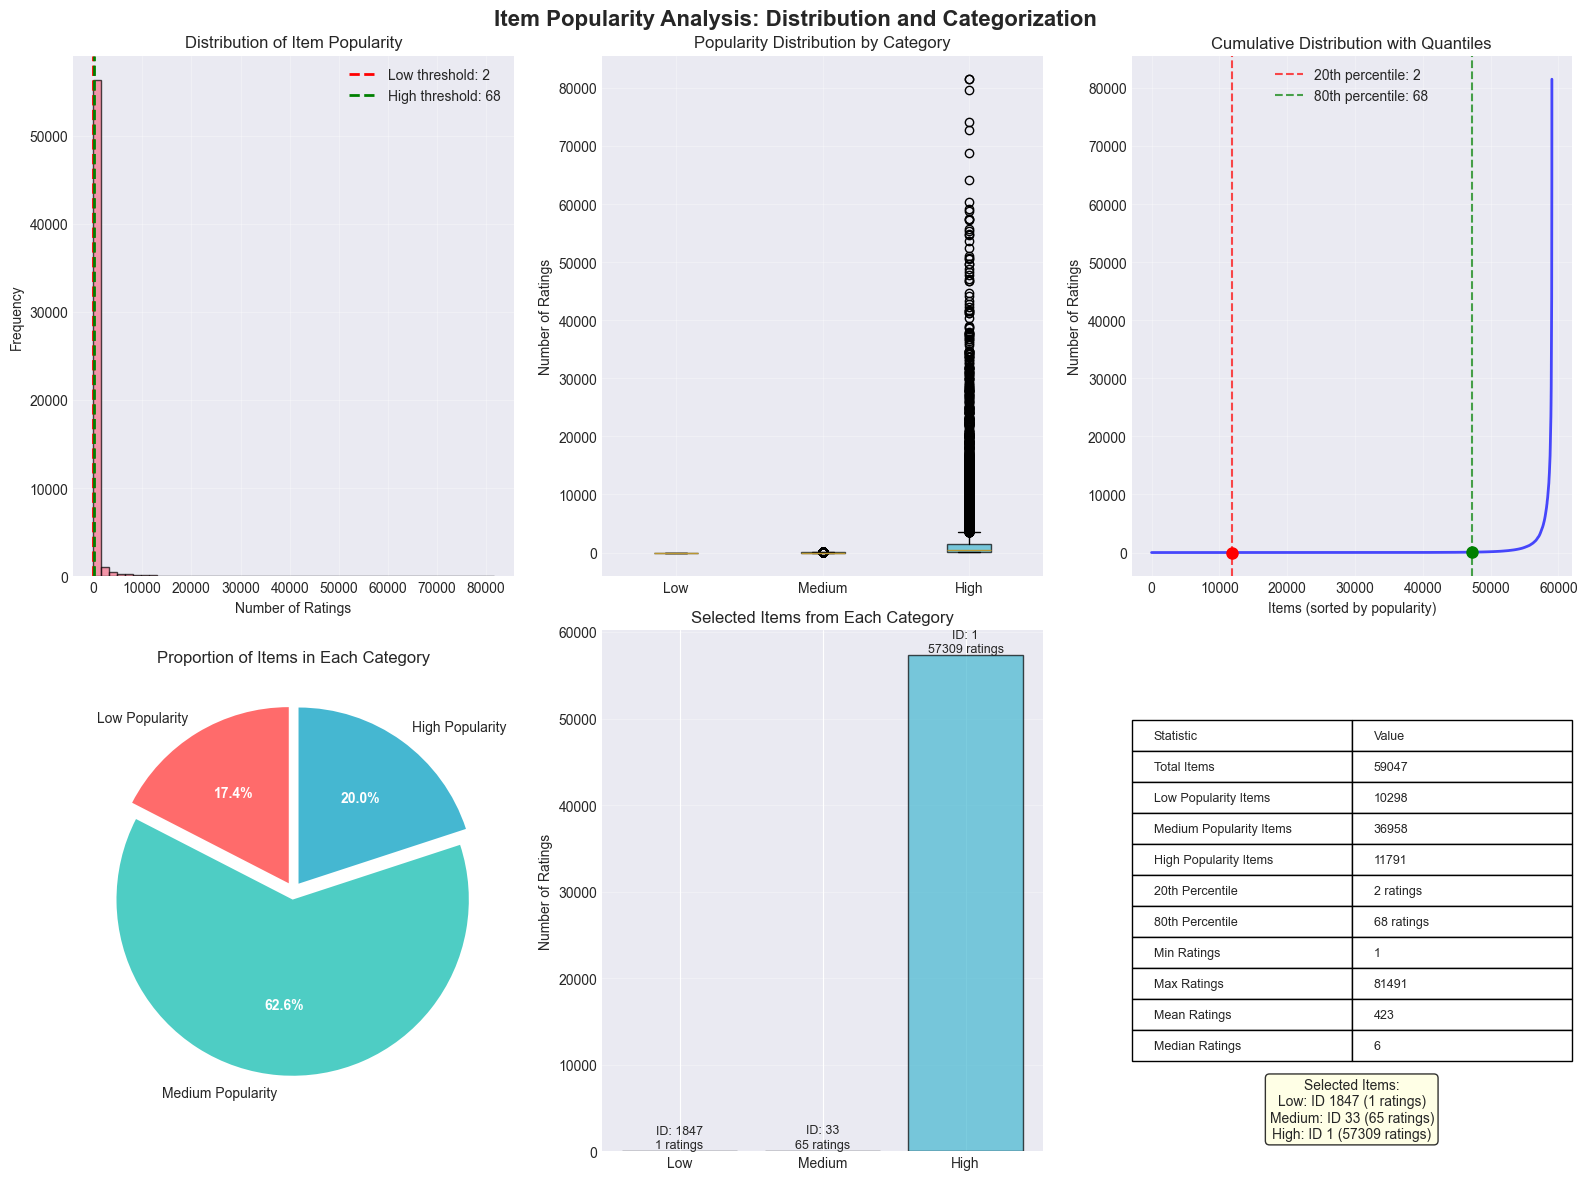

POPULARITY CATEGORY SUMMARY
Low popularity threshold (< 2 ratings): 10298 items
Medium popularity (2-68 ratings): 36958 items
High popularity (> 68 ratings): 11791 items

Selected items for analysis:
  Low: Item 1847 - 1 ratings
  Medium: Item 33 - 65 ratings
  High: Item 1 - 57309 ratings


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.patches import Rectangle

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Create figure with subplots
fig = plt.figure(figsize=(16, 12))

# 1. Distribution plot with thresholds
ax1 = plt.subplot(2, 3, 1)
item_popularity.hist(bins=50, edgecolor='black', alpha=0.7)
ax1.axvline(low_th, color='red', linestyle='--', linewidth=2, label=f'Low threshold: {low_th:.0f}')
ax1.axvline(high_th, color='green', linestyle='--', linewidth=2, label=f'High threshold: {high_th:.0f}')
ax1.set_xlabel('Number of Ratings')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Item Popularity')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Box plot by category
ax2 = plt.subplot(2, 3, 2)
categories_data = [
    item_popularity[item_popularity < low_th],
    item_popularity[(item_popularity >= low_th) & (item_popularity <= high_th)],
    item_popularity[item_popularity > high_th]
]
box = ax2.boxplot(categories_data, patch_artist=True, labels=['Low', 'Medium', 'High'])
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax2.set_ylabel('Number of Ratings')
ax2.set_title('Popularity Distribution by Category')
ax2.grid(True, alpha=0.3)

# 3. Quantile visualization
ax3 = plt.subplot(2, 3, 3)
sorted_popularity = np.sort(item_popularity.values)
quantile_points = [0.2, 0.8]
quantile_values = [low_th, high_th]

ax3.plot(sorted_popularity, 'b-', alpha=0.7, linewidth=2)
for q, val, color, label in zip(quantile_points, quantile_values, ['red', 'green'], ['20th percentile', '80th percentile']):
    idx = int(len(sorted_popularity) * q)
    ax3.axvline(idx, color=color, linestyle='--', alpha=0.7, label=f'{label}: {val:.0f}')
    ax3.plot(idx, val, 'o', color=color, markersize=8)
ax3.set_xlabel('Items (sorted by popularity)')
ax3.set_ylabel('Number of Ratings')
ax3.set_title('Cumulative Distribution with Quantiles')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Category proportions (pie chart)
ax4 = plt.subplot(2, 3, 4)
category_counts = [
    len(low_pop_items),
    len(medium_pop_items),
    len(high_pop_items)
]
category_labels = ['Low Popularity', 'Medium Popularity', 'High Popularity']
explode = (0.05, 0.05, 0.05)
wedges, texts, autotexts = ax4.pie(category_counts, labels=category_labels, autopct='%1.1f%%',
                                  explode=explode, colors=colors, startangle=90)
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
ax4.set_title('Proportion of Items in Each Category')

# 5. Bar chart with selected items
ax5 = plt.subplot(2, 3, 5)
categories = ['Low', 'Medium', 'High']
selected_items = [I_low, I_medium, I_high]
selected_popularities = [item_popularity.loc[i] for i in selected_items]

bars = ax5.bar(categories, selected_popularities, color=colors, alpha=0.7, edgecolor='black')
ax5.set_ylabel('Number of Ratings')
ax5.set_title('Selected Items from Each Category')
ax5.grid(True, alpha=0.3, axis='y')

#  value labels on bars
for bar, pop in zip(bars, selected_popularities):
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width()/2., height,
             f'ID: {selected_items[bars.index(bar)]}\n{pop:.0f} ratings',
             ha='center', va='bottom', fontsize=9)

# 6. Statistics table
ax6 = plt.subplot(2, 3, 6)
ax6.axis('tight')
ax6.axis('off')

stats_data = [
    ['Statistic', 'Value'],
    ['Total Items', len(item_popularity)],
    ['Low Popularity Items', len(low_pop_items)],
    ['Medium Popularity Items', len(medium_pop_items)],
    ['High Popularity Items', len(high_pop_items)],
    ['20th Percentile', f'{low_th:.0f} ratings'],
    ['80th Percentile', f'{high_th:.0f} ratings'],
    ['Min Ratings', f'{item_popularity.min():.0f}'],
    ['Max Ratings', f'{item_popularity.max():.0f}'],
    ['Mean Ratings', f'{item_popularity.mean():.0f}'],
    ['Median Ratings', f'{item_popularity.median():.0f}']
]

table = ax6.table(cellText=stats_data, cellLoc='left', loc='center',
                  colWidths=[0.5, 0.5], edges='closed')
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 1.5)

#  selected items info
selected_info = f"Selected Items:\nLow: ID {I_low} ({item_popularity.loc[I_low]:.0f} ratings)\n"
selected_info += f"Medium: ID {I_medium} ({item_popularity.loc[I_medium]:.0f} ratings)\n"
selected_info += f"High: ID {I_high} ({item_popularity.loc[I_high]:.0f} ratings)"
ax6.text(0.5, 0.02, selected_info, transform=ax6.transAxes,
         fontsize=10, ha='center', va='bottom',
         bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

#  overall title
plt.suptitle('Item Popularity Analysis: Distribution and Categorization', 
             fontsize=16, fontweight='bold', y=0.98)

plt.tight_layout()
plt.show()

#  summary statistics
print("="*60)
print("POPULARITY CATEGORY SUMMARY")
print("="*60)
print(f"Low popularity threshold (< {low_th:.0f} ratings): {len(low_pop_items)} items")
print(f"Medium popularity ({low_th:.0f}-{high_th:.0f} ratings): {len(medium_pop_items)} items")
print(f"High popularity (> {high_th:.0f} ratings): {len(high_pop_items)} items")
print("\nSelected items for analysis:")
print(f"  Low: Item {I_low} - {item_popularity.loc[I_low]:.0f} ratings")
print(f"  Medium: Item {I_medium} - {item_popularity.loc[I_medium]:.0f} ratings")
print(f"  High: Item {I_high} - {item_popularity.loc[I_high]:.0f} ratings")
print("="*60)

Part 1: PCA Method with Mean-Filling

In [29]:
# Target items (already selected earlier)
I1 = I_low      # or your selected item ID
I2 = I_medium   # or your selected item ID

# Calculate average rating for each target item
mean_I1 = ratings[ratings['movieId'] == I1]['rating'].mean()
mean_I2 = ratings[ratings['movieId'] == I2]['rating'].mean()

mean_I1, mean_I2

(2.0, 3.023076923076923)

In [28]:


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Calculate average rating for each target item
mean_I1 = ratings[ratings['movieId'] == I1]['rating'].mean()
mean_I2 = ratings[ratings['movieId'] == I2]['rating'].mean()

# Create a DataFrame to save
results_df = pd.DataFrame({
    'Item_ID': [I1, I2],
    'Category': ['Low Popularity', 'Medium Popularity'],
    'Number_of_Ratings': [item_popularity.loc[I1], item_popularity.loc[I2]],
    'Average_Rating': [mean_I1, mean_I2]
})

# Save to CSV
results_df.to_csv('item_comparison_results.csv', index=False)
print("Results saved to 'item_comparison_results.csv'")



Results saved to 'item_comparison_results.csv'


In [32]:


# Target items
I1 = I_low      # Replace with your selected item ID
I2 = I_medium   # Replace with your selected item ID

# Filter only rows for target items
ratings_target = ratings[ratings['movieId'].isin([I1, I2])]

# Create user-item matrix for target items only
user_item_matrix = ratings_target.pivot(
    index='userId',
    columns='movieId',
    values='rating'
)

# Calculate mean rating for each target item
mean_I1 = user_item_matrix[I1].mean(skipna=True)
mean_I2 = user_item_matrix[I2].mean(skipna=True)

# Mean-Filling
user_item_matrix_filled = user_item_matrix.copy()
user_item_matrix_filled[I1] = user_item_matrix_filled[I1].fillna(mean_I1)
user_item_matrix_filled[I2] = user_item_matrix_filled[I2].fillna(mean_I2)

user_item_matrix_filled.head()


movieId  33    1847
userId             
215       5.0   2.0
5135      4.0   2.0
8277      3.0   2.0
9826      3.0   2.0
11353     4.0   2.0

In [33]:


# Calculate average rating for each item
item_mean_ratings = ratings.groupby('movieId')['rating'].mean()

# Preview
item_mean_ratings.head()


movieId
1    3.893708
2    3.251527
3    3.142028
4    2.853547
5    3.058434
Name: rating, dtype: float64

In [ ]:


#  Calculate mean rating for each item
item_mean_ratings = ratings.groupby('movieId')['rating'].mean()

# Merge mean rating into original dataframe
ratings = ratings.merge(item_mean_ratings.rename('mean_rating'), on='movieId')

#  Compute centered rating (rating - mean_rating)
ratings['rating_centered'] = ratings['rating'] - ratings['mean_rating']

# Preview for raitings
ratings[['userId', 'movieId', 'rating', 'mean_rating', 'rating_centered']].head()


userId  movieId  rating  mean_rating  rating_centered
0       1      296     5.0     4.188912         0.811088
1       3      296     5.0     4.188912         0.811088
2       4      296     4.0     4.188912        -0.188912
3       5      296     4.0     4.188912        -0.188912
4       7      296     4.0     4.188912        -0.188912

In [35]:


#  Calculate mean rating for each item
item_mean_ratings = ratings.groupby('movieId')['rating'].mean()

#  Create user-item matrix 
#  we limit to top 500 items by popularity to avoid MemoryError
top_items = ratings['movieId'].value_counts().head(500).index
ratings_subset = ratings[ratings['movieId'].isin(top_items)]

user_item_matrix = ratings_subset.pivot(
    index='userId',
    columns='movieId',
    values='rating'
)

#  Mean-centering (difference from item mean)
user_item_matrix_centered = user_item_matrix.sub(user_item_matrix.mean(), axis=1)

#   covariance matrix
cov_matrix = user_item_matrix_centered.cov()  # pandas automatically handles NaN

cov_matrix.head()


movieId    1         2         3         5         6         7         10      \
movieId                                                                         
1        0.849258  0.283423  0.168057  0.207710  0.099964  0.172916  0.187115   
2        0.283423  0.921315  0.362583  0.423530  0.096391  0.324111  0.247875   
3        0.168057  0.362583  1.016957  0.469277  0.130488  0.295178  0.250375   
5        0.207710  0.423530  0.469277  0.993234  0.112851  0.374613  0.297549   
6        0.099964  0.096391  0.130488  0.112851  0.770657  0.113375  0.162722   

movieId    11        16        17      ...    111759    112556    112852  \
movieId                                ...                                 
1        0.181039  0.078141  0.183170  ...  0.180275  0.134951  0.239511   
2        0.253347  0.106274  0.180555  ...  0.218164  0.141438  0.222132   
3        0.287095  0.124064  0.094308  ...  0.146966  0.131441  0.194919   
5        0.365742  0.115453  0.201571  ...  0.142216  0.097066  0.144506   
6        0.101533  0.262599  0.089163  ...  0.146455  0.163132  0.093866   

movieId    115713    116797    122882    122886    122904    134130    134853  
movieId                                                                        
1        0.144748  0.120874  0.226270  0.267973  0.207090  0.166360  0.374772  
2        0.126039  0.158858  0.140922  0.172756  0.200454  0.161684  0.184645  
3        0.153322  0.197907  0.004772  0.308072  0.192985  0.164192  0.329681  
5        0.108070  0.142385  0.096985  0.276355  0.205781  0.273541  0.289960  
6        0.142680  0.129619  0.162269  0.120247  0.128935  0.122349  0.122771  

[5 rows x 500 columns]

In [ ]:


# اختار subset من العناصر لتجنب MemoryError
top_items = ratings['movieId'].value_counts().head(500).index  # top 500 items by popularity

# Filter ratings to these items
ratings_subset = ratings[ratings['movieId'].isin(top_items)]

# Create user-item matrix (Memory-Safe)
user_item_matrix = ratings_subset.pivot(
    index='userId',
    columns='movieId',
    values='rating'
)

# Mean-filling
user_item_matrix_filled = user_item_matrix.fillna(user_item_matrix.mean())

# Mean-centering
user_item_matrix_centered = user_item_matrix_filled.sub(user_item_matrix_filled.mean(), axis=1)

# Covariance matrix
cov_matrix = user_item_matrix_centered.cov()

cov_matrix.head()


movieId    1         2         3         5         6         7         10      \
movieId                                                                         
1        0.300591  0.027612  0.008050  0.009830  0.008872  0.008272  0.017558   
2        0.027612  0.137857  0.009210  0.011439  0.004870  0.008159  0.017525   
3        0.008050  0.009210  0.074134  0.015395  0.004133  0.008753  0.006116   
5        0.009830  0.011439  0.015395  0.071852  0.003846  0.011237  0.007445   
6        0.008872  0.004870  0.004133  0.003846  0.117027  0.004217  0.010258   

movieId    11        16        17      ...    111759    112556    112852  \
movieId                                ...                                 
1        0.009875  0.004843  0.012285  ...  0.006736  0.005089  0.012000   
2        0.010544  0.004714  0.006381  ...  0.003879  0.002224  0.004972   
3        0.006734  0.002761  0.002779  ...  0.000511  0.000500  0.000713   
5        0.009037  0.002500  0.005661  ...  0.000657  0.000538  0.000785   
6        0.004005  0.016573  0.004713  ...  0.002328  0.002621  0.001419   

movieId    115713    116797    122882    122886    122904    134130    134853  
movieId                                                                        
1        0.005361  0.005365  0.009441  0.011145  0.008342  0.007479  0.017613  
2        0.002035  0.002607  0.002710  0.003409  0.003806  0.003302  0.003450  
3        0.000511  0.000637  0.000196  0.000916  0.000501  0.000563  0.000928  
5        0.000610  0.000719  0.000699  0.001153  0.000840  0.001281  0.001160  
6        0.002158  0.001698  0.002774  0.001727  0.001684  0.001917  0.001466  

[5 rows x 500 columns]

In [36]:


# Target items
I1 = I_low      
I2 = I_medium

#  subset including target items + top 500 popular items
top_items = ratings['movieId'].value_counts().head(500).index.tolist()
items_subset = list(set(top_items) | {I1, I2})

ratings_subset = ratings[ratings['movieId'].isin(items_subset)]

# User-item matrix
user_item_matrix = ratings_subset.pivot(
    index='userId',
    columns='movieId',
    values='rating'
)

# Mean-filling and mean-centering
user_item_matrix_filled = user_item_matrix.fillna(user_item_matrix.mean())
user_item_matrix_centered = user_item_matrix_filled.sub(user_item_matrix_filled.mean(), axis=1)

# Covariance matrix
cov_matrix = user_item_matrix_centered.cov()

# Function to get top N peers
def top_peers(cov_matrix, item_id, N):
    if item_id not in cov_matrix.columns:
        return pd.Series([], name=f'Target item {item_id} not in covariance matrix')
    sorted_items = cov_matrix[item_id].sort_values(ascending=False).drop(item_id, errors='ignore')
    return sorted_items.head(N)

# Top 5 and Top 10 peers
top5_I1 = top_peers(cov_matrix, I1, 5)
top10_I1 = top_peers(cov_matrix, I1, 10)
top5_I2 = top_peers(cov_matrix, I2, 5)
top10_I2 = top_peers(cov_matrix, I2, 10)

top5_I1, top10_I1, top5_I2, top10_I2


(movieId
 1       0.0
 3421    0.0
 3793    0.0
 3785    0.0
 3753    0.0
 Name: 1847, dtype: float64,
 movieId
 1       0.0
 3421    0.0
 3793    0.0
 3785    0.0
 3753    0.0
 3751    0.0
 3717    0.0
 3671    0.0
 3623    0.0
 3578    0.0
 Name: 1847, dtype: float64,
 movieId
 780     0.000152
 2628    0.000139
 1101    0.000120
 1552    0.000119
 1203    0.000109
 Name: 33, dtype: float64,
 movieId
 780     0.000152
 2628    0.000139
 1101    0.000120
 1552    0.000119
 1203    0.000109
 587     0.000108
 440     0.000103
 1       0.000098
 1961    0.000098
 1580    0.000097
 Name: 33, dtype: float64)

In [37]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\VICTUS\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


User-item matrix shape: (78188, 6)
Number of users: 78188
Number of items (target + 5 peers): 6

First 5 users in reduced space:
[[-0.09907489  1.41942965]
 [ 0.17192118  0.3308465 ]
 [-1.27798808 -1.70883099]
 [ 0.10358948 -0.02341753]
 [ 0.10358948 -0.02341753]]

PCA Explained variance ratio: [0.41752096 0.22571121]
Total explained variance: 0.643


OSError: [Errno 22] Invalid argument: 'pca_analysis_target_and_peers.pdf'

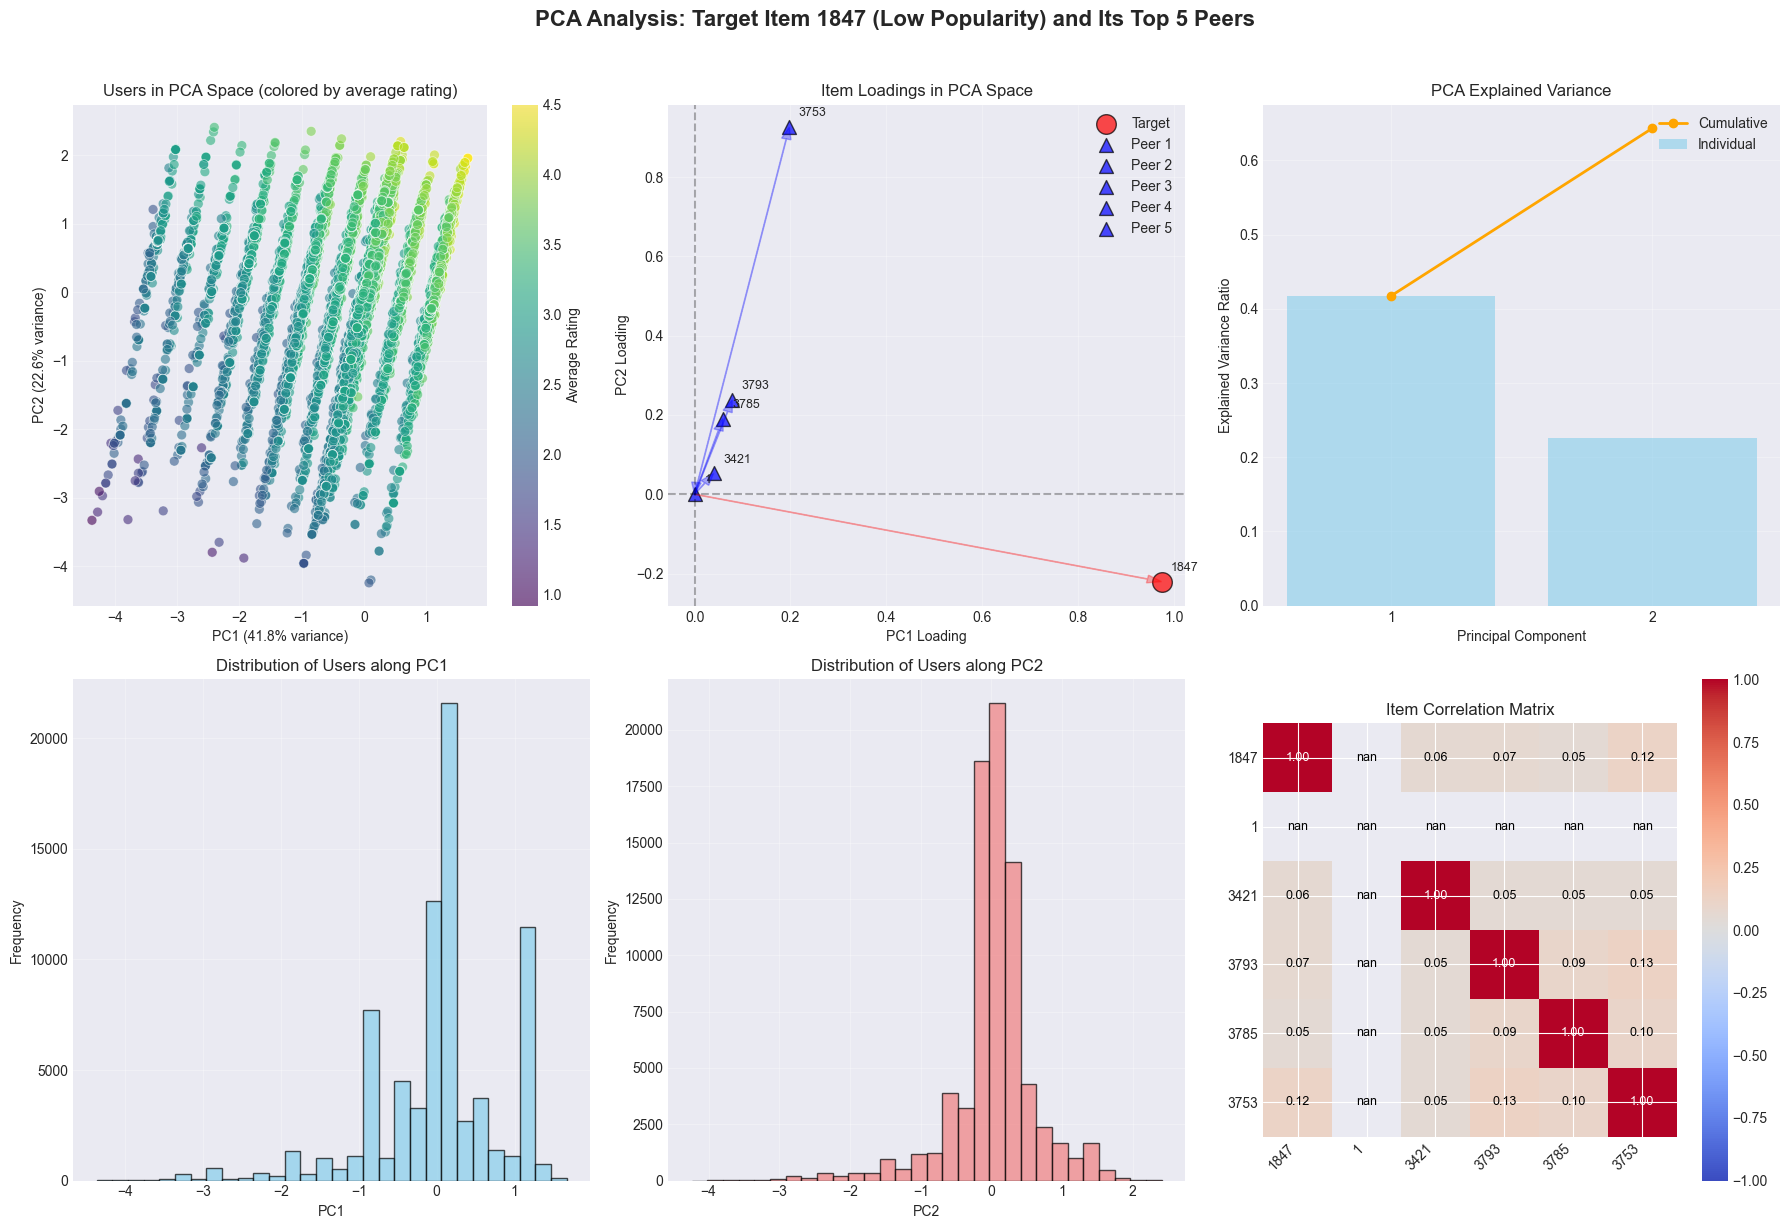

In [46]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.patches import Ellipse

# Target item and its top 5 peers (from previous task)
I_target = I1
top5_peers_items = top5_I1.index.tolist()  # top 5 peers from Task 7

# Filter ratings for target item and its top 5 peers
items_of_interest = [I_target] + top5_peers_items
ratings_subset = ratings[ratings['movieId'].isin(items_of_interest)]

# Create user-item matrix
user_item_matrix = ratings_subset.pivot(
    index='userId',
    columns='movieId',
    values='rating'
)

# Mean-filling for missing ratings
user_item_matrix_filled = user_item_matrix.fillna(user_item_matrix.mean())

# Mean-centering
user_item_matrix_centered = user_item_matrix_filled.sub(user_item_matrix_filled.mean(), axis=1)

print(f"User-item matrix shape: {user_item_matrix_centered.shape}")
print(f"Number of users: {user_item_matrix_centered.shape[0]}")
print(f"Number of items (target + 5 peers): {user_item_matrix_centered.shape[1]}")

# Apply PCA to reduce dimensionality
pca = PCA(n_components=2)  # 2 components for 2D visualization
user_reduced_space = pca.fit_transform(user_item_matrix_centered)

# Show first 5 users in reduced space
print("\nFirst 5 users in reduced space:")
print(user_reduced_space[:5])

# Show PCA explained variance
print(f"\nPCA Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total explained variance: {sum(pca.explained_variance_ratio_):.3f}")

# Get item names if available (assuming you have a movies DataFrame)
try:
    # If you have a movies DataFrame with 'movieId' and 'title'
    item_names = {}
    for item_id in items_of_interest:
        item_names[item_id] = movies[movies['movieId'] == item_id]['title'].values[0]
except:
    # Fallback to just using IDs
    item_names = {item_id: f"Item {item_id}" for item_id in items_of_interest}

# Create a DataFrame for easier plotting
user_reduced_df = pd.DataFrame(user_reduced_space, 
                               columns=['PC1', 'PC2'],
                               index=user_item_matrix_centered.index)

# Add average ratings for each user across items
user_reduced_df['avg_rating'] = user_item_matrix_filled.mean(axis=1)

# Create visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle(f'PCA Analysis: Target Item {I_target} (Low Popularity) and Its Top 5 Peers',
            fontsize=16, fontweight='bold', y=1.02)

# 1. Scatter plot of users in PCA space
ax1 = axes[0, 0]
scatter = ax1.scatter(user_reduced_df['PC1'], user_reduced_df['PC2'], 
                     c=user_reduced_df['avg_rating'], 
                     cmap='viridis', alpha=0.6, s=50, edgecolors='white', linewidth=0.5)
ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
ax1.set_title('Users in PCA Space (colored by average rating)')
plt.colorbar(scatter, ax=ax1, label='Average Rating')
ax1.grid(True, alpha=0.3)

# 2. Item loadings in PCA space
ax2 = axes[0, 1]
# Get PCA loadings (how each item contributes to PCs)
loadings = pca.components_.T  # Transpose to get items as rows
for i, item_id in enumerate(items_of_interest):
    x, y = loadings[i, 0], loadings[i, 1]
    color = 'red' if item_id == I_target else 'blue'
    marker = 'o' if item_id == I_target else '^'
    size = 200 if item_id == I_target else 100
    label = f'Target' if item_id == I_target else f'Peer {i}'
    ax2.scatter(x, y, color=color, marker=marker, s=size, alpha=0.7, edgecolors='black', label=label)
    # Add text label
    offset = 0.02
    ax2.text(x + offset, y + offset, f"{item_id}", fontsize=9, ha='left', va='bottom')

# Draw arrows from origin
for i, item_id in enumerate(items_of_interest):
    x, y = loadings[i, 0], loadings[i, 1]
    color = 'red' if item_id == I_target else 'blue'
    ax2.arrow(0, 0, x, y, color=color, alpha=0.3, head_width=0.02, length_includes_head=True)

ax2.axhline(y=0, color='k', linestyle='--', alpha=0.3)
ax2.axvline(x=0, color='k', linestyle='--', alpha=0.3)
ax2.set_xlabel('PC1 Loading')
ax2.set_ylabel('PC2 Loading')
ax2.set_title('Item Loadings in PCA Space')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Explained variance
ax3 = axes[0, 2]
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
components = range(1, min(10, len(cumulative_variance)) + 1)
ax3.bar(components, pca.explained_variance_ratio_[:len(components)], 
        alpha=0.6, color='skyblue', label='Individual')
ax3.plot(components, cumulative_variance[:len(components)], 
         marker='o', color='orange', linewidth=2, label='Cumulative')
ax3.set_xlabel('Principal Component')
ax3.set_ylabel('Explained Variance Ratio')
ax3.set_title('PCA Explained Variance')
ax3.set_xticks(components)
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Distribution along PC1
ax4 = axes[1, 0]
ax4.hist(user_reduced_df['PC1'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
ax4.set_xlabel('PC1')
ax4.set_ylabel('Frequency')
ax4.set_title('Distribution of Users along PC1')
ax4.grid(True, alpha=0.3)

# 5. Distribution along PC2
ax5 = axes[1, 1]
ax5.hist(user_reduced_df['PC2'], bins=30, alpha=0.7, color='lightcoral', edgecolor='black')
ax5.set_xlabel('PC2')
ax5.set_ylabel('Frequency')
ax5.set_title('Distribution of Users along PC2')
ax5.grid(True, alpha=0.3)

# 6. Item correlation heatmap (before PCA)
ax6 = axes[1, 2]
# Calculate correlation matrix for the 6 items
item_correlation = user_item_matrix_filled.corr()
mask = np.triu(np.ones_like(item_correlation, dtype=bool))
im = ax6.imshow(item_correlation, cmap='coolwarm', vmin=-1, vmax=1)
ax6.set_xticks(range(len(items_of_interest)))
ax6.set_yticks(range(len(items_of_interest)))
ax6.set_xticklabels([f"{id}" for id in items_of_interest], rotation=45, ha='right')
ax6.set_yticklabels([f"{id}" for id in items_of_interest])
ax6.set_title('Item Correlation Matrix')

# Add correlation values
for i in range(len(items_of_interest)):
    for j in range(len(items_of_interest)):
        if i != j or i <= j:  # Show upper triangle and diagonal
            text_color = 'white' if abs(item_correlation.iloc[i, j]) > 0.5 else 'black'
            ax6.text(j, i, f'{item_correlation.iloc[i, j]:.2f}',
                    ha='center', va='center', color=text_color, fontsize=9)

plt.colorbar(im, ax=ax6)

plt.tight_layout()

# Save the visualization
plt.savefig('pca_analysis_target_and_peers.png', dpi=300, bbox_inches='tight')
plt.savefig('pca_analysis_target_and_peers.pdf', bbox_inches='tight')
print("\nVisualization saved as 'pca_analysis_target_and_peers.png' and '.pdf'")

plt.show()

# Additional analysis
print("\n" + "="*60)
print("PCA ANALYSIS SUMMARY")
print("="*60)
print(f"Target item: {I_target}")
print(f"Top 5 peers: {top5_peers_items}")
print(f"Number of users in analysis: {len(user_reduced_df)}")
print(f"Total explained variance by 2 PCs: {sum(pca.explained_variance_ratio_):.1%}")

# Analyze PCA loadings
print("\nItem loadings on principal components:")
for i, item_id in enumerate(items_of_interest):
    pc1_loading = loadings[i, 0]
    pc2_loading = loadings[i, 1]
    item_type = "TARGET" if item_id == I_target else "peer"
    print(f"Item {item_id} ({item_type}): PC1={pc1_loading:.3f}, PC2={pc2_loading:.3f}")

# Check if target item clusters with its peers
target_pc1 = loadings[items_of_interest.index(I_target), 0]
target_pc2 = loadings[items_of_interest.index(I_target), 1]

peer_pc1_mean = np.mean([loadings[i, 0] for i, item_id in enumerate(items_of_interest) if item_id != I_target])
peer_pc2_mean = np.mean([loadings[i, 1] for i, item_id in enumerate(items_of_interest) if item_id != I_target])

distance = np.sqrt((target_pc1 - peer_pc1_mean)**2 + (target_pc2 - peer_pc2_mean)**2)
print(f"\nDistance between target and average peer position in loading space: {distance:.3f}")
if distance < 0.5:
    print("Interpretation: Target item clusters closely with its peers in PCA space")
else:
    print("Interpretation: Target item is somewhat separated from its peers in PCA space")

print("="*60)

In [47]:


# Target item and its top 5 peers (from previous task)
I_target = I1
top5_peers_items = top5_I1.index.tolist()  # top 5 peers from Task 7

# Filter ratings for target item and its top 5 peers
items_of_interest = [I_target] + top5_peers_items
ratings_subset = ratings[ratings['movieId'].isin(items_of_interest)]

# Create user-item matrix
user_item_matrix = ratings_subset.pivot(
    index='userId',
    columns='movieId',
    values='rating'
)

# Mean-filling for missing ratings
user_item_matrix_filled = user_item_matrix.fillna(user_item_matrix.mean())

# Mean-centering
user_item_matrix_centered = user_item_matrix_filled.sub(user_item_matrix_filled.mean(), axis=1)

# Apply PCA to reduce dimensionality
pca = PCA(n_components=2)  # 2 components for example, can be increased
user_reduced_space = pca.fit_transform(user_item_matrix_centered)

# Show first 5 users in reduced space
user_reduced_space[:5]


array([[-0.09907489,  1.41942965],
       [ 0.17192118,  0.3308465 ],
       [-1.27798808, -1.70883099],
       [ 0.10358948, -0.02341753],
       [ 0.10358948, -0.02341753]])

In [42]:


# Target items
target_items = [I1, I2]

# Function to predict ratings using top N peers
def predict_ratings(ratings, target_item, top_peers):
    # Create user-item matrix for target + peers
    items_of_interest = [target_item] + list(top_peers.index)
    ratings_subset = ratings[ratings['movieId'].isin(items_of_interest)]
    user_item_matrix = ratings_subset.pivot(index='userId', columns='movieId', values='rating')

    # Mean-filling for peers only
    user_item_matrix_filled = user_item_matrix.copy()
    for item in top_peers.index:
        user_item_matrix_filled[item] = user_item_matrix_filled[item].fillna(user_item_matrix_filled[item].mean())

    # Mean of target item
    mean_target = user_item_matrix[target_item].mean(skipna=True)

    # Predict missing ratings
    predicted_ratings = {}
    for user in user_item_matrix.index:
        if pd.isna(user_item_matrix.loc[user, target_item]):
            # Weighted sum over top peers
            numerator = 0
            denominator = 0
            for peer in top_peers.index:
                peer_rating = user_item_matrix_filled.loc[user, peer]
                weight = top_peers[peer]
                numerator += weight * (peer_rating - user_item_matrix_filled[peer].mean())
                denominator += abs(weight)
            if denominator != 0:
                predicted_ratings[user] = mean_target + numerator / denominator
            else:
                predicted_ratings[user] = mean_target  # fallback if denominator=0
        else:
            predicted_ratings[user] = user_item_matrix.loc[user, target_item]  # keep original rating
    return pd.Series(predicted_ratings)

# Predict for I1 and I2 using Top 5 peers
pred_I1 = predict_ratings(ratings, I1, top5_I1)
pred_I2 = predict_ratings(ratings, I2, top5_I2)

# Show first 10 predicted ratings
pred_I1.head(10), pred_I2.head(10)


(2     2.0
 3     2.0
 4     2.0
 5     2.0
 8     2.0
 10    2.0
 12    2.0
 13    2.0
 18    2.0
 19    2.0
 dtype: float64,
 3     3.255107
 4     2.696278
 5     3.171991
 6     3.151620
 8     2.913249
 9     3.132989
 10    2.934135
 11    2.727097
 12    2.933027
 13    3.136179
 dtype: float64)

In [43]:
pip install dask



   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ------- -------------------------------- 0.3/1.5 MB ? eta -:--:--
   ------- -------------------------------- 0.3/1.5 MB ? eta -:--:--
   ------- -------------------------------- 0.3/1.5 MB ? eta -:--:--
   ------- -------------------------------- 0.3/1.5 MB ? eta -:--:--
   -------------- ------------------------- 0.5/1.5 MB 381.6 kB/s eta 0:00:03
   -------------- ------------------------- 0.5/1.5 MB 381.6 kB/s eta 0:00:03
   -------------- ------------------------- 0.5/1.5 MB 381.6 kB/s eta 0:00:03
   -------------- ------------------------- 0.5/1.5 MB 381.6 kB/s eta 0:00:03
   -------------- ------------------------- 0.5/1.5 MB 381.6 kB/s eta 0:00:03
   -------------- ------------------------- 0.5/1.5 MB 381.6 kB/s eta 0:00:03
   -------------- ------------------------- 0.5/


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\VICTUS\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [44]:


# Target item and its top 10 peers (from Task 7)
I_target = I1  # Example: can also use I2
top10_peers_items = top10_I1.index.tolist()  # top 10 peers from Task 7

# Filter ratings for target item + its top 10 peers
items_of_interest = [I_target] + top10_peers_items
ratings_subset = ratings[ratings['movieId'].isin(items_of_interest)]

# user-item matrix
user_item_matrix = ratings_subset.pivot(
    index='userId',
    columns='movieId',
    values='rating'
)

# Mean-filling for missing ratings
user_item_matrix_filled = user_item_matrix.fillna(user_item_matrix.mean())

# Mean-centering
user_item_matrix_centered = user_item_matrix_filled.sub(user_item_matrix_filled.mean(), axis=1)

# Apply PCA to reduce dimensionality
pca = PCA(n_components=2)  # 2 components as example
user_reduced_space = pca.fit_transform(user_item_matrix_centered)

# Show first 5 users in reduced space
user_reduced_space[:5]


array([[ 0.56926303,  1.32623865],
       [ 0.48783367,  0.37168319],
       [-1.27845971,  0.01727457],
       [ 0.08381269, -0.06315965],
       [ 0.08381269, -0.06315965]])

In [45]:


#  predict ratings using top N peers
def predict_ratings_topN(ratings, target_item, top_peers):
    # Create user-item matrix for target + peers
    items_of_interest = [target_item] + list(top_peers.index)
    ratings_subset = ratings[ratings['movieId'].isin(items_of_interest)]
    user_item_matrix = ratings_subset.pivot(index='userId', columns='movieId', values='rating')

    # Mean-filling for peers only
    user_item_matrix_filled = user_item_matrix.copy()
    for item in top_peers.index:
        user_item_matrix_filled[item] = user_item_matrix_filled[item].fillna(user_item_matrix_filled[item].mean())

    # Mean of target item
    mean_target = user_item_matrix[target_item].mean(skipna=True)

    # Predict missing ratings
    predicted_ratings = {}
    for user in user_item_matrix.index:
        if pd.isna(user_item_matrix.loc[user, target_item]):
            numerator = 0
            denominator = 0
            for peer in top_peers.index:
                peer_rating = user_item_matrix_filled.loc[user, peer]
                weight = top_peers[peer]
                numerator += weight * (peer_rating - user_item_matrix_filled[peer].mean())
                denominator += abs(weight)
            if denominator != 0:
                predicted_ratings[user] = mean_target + numerator / denominator
            else:
                predicted_ratings[user] = mean_target  # fallback
        else:
            predicted_ratings[user] = user_item_matrix.loc[user, target_item]
    return pd.Series(predicted_ratings)

# Predict for I1 and I2 using Top 10 peers
pred_I1_top10 = predict_ratings_topN(ratings, I1, top10_I1)
pred_I2_top10 = predict_ratings_topN(ratings, I2, top10_I2)

#  first 10 predicted ratings
pred_I1_top10.head(10), pred_I2_top10.head(10)


(2     2.0
 3     2.0
 4     2.0
 5     2.0
 8     2.0
 10    2.0
 12    2.0
 13    2.0
 18    2.0
 19    2.0
 dtype: float64,
 2     3.067129
 3     3.161962
 4     2.841387
 5     3.061515
 6     3.094953
 8     3.127000
 9     3.232770
 10    2.939477
 11    2.857578
 12    3.019308
 dtype: float64)

In [41]:
import pandas as pd

# Combine predictions into a single DataFrame
comparison_I1 = pd.DataFrame({
    'Pred_Top5': pred_I1,
    'Pred_Top10': pred_I1_top10
})

comparison_I2 = pd.DataFrame({
    'Pred_Top5': pred_I2,
    'Pred_Top10': pred_I2_top10
})

# Compute difference
comparison_I1['Difference'] = comparison_I1['Pred_Top10'] - comparison_I1['Pred_Top5']
comparison_I2['Difference'] = comparison_I2['Pred_Top10'] - comparison_I2['Pred_Top5']

# Summary statistics
summary_I1 = comparison_I1.describe()
summary_I2 = comparison_I2.describe()

summary_I1, summary_I2


(       Pred_Top5  Pred_Top10  Difference
 count    77751.0     93555.0     77751.0
 mean         2.0         2.0         0.0
 std          0.0         0.0         0.0
 min          2.0         2.0         0.0
 25%          2.0         2.0         0.0
 50%          2.0         2.0         0.0
 75%          2.0         2.0         0.0
 max          2.0         2.0         0.0,
           Pred_Top5     Pred_Top10    Difference
 count  74016.000000  107628.000000  74016.000000
 mean       3.023174       3.023133     -0.004149
 std        0.360832       0.239735      0.154127
 min        0.500000       0.500000     -1.033160
 25%        2.855738       2.933128     -0.089069
 50%        3.053063       3.032220     -0.009189
 75%        3.225121       3.133403      0.081944
 max        5.000000       5.000000      0.855181)

Part 2: PCA Method with Maximum Likelihood Estimation

In [42]:
import numpy as np
import pandas as pd

# افترض إن user_item_matrix موجود بالفعل
# NaN معناها المستخدم ما قيمش العنصر

items = user_item_matrix.columns
cov_matrix = pd.DataFrame(np.zeros((len(items), len(items))), index=items, columns=items)

for i, item_i in enumerate(items):
    for j, item_j in enumerate(items):
        if j < i:
            continue
        # Users who rated both items
        mask = user_item_matrix[[item_i, item_j]].notna().all(axis=1)
        if mask.sum() >= 2:  # Minimum 2 users to compute covariance
            cov_ij = np.cov(user_item_matrix.loc[mask, item_i],
                            user_item_matrix.loc[mask, item_j])[0, 1]
        else:
            cov_ij = 0.0  # If not enough users, set covariance to 0
        cov_matrix.loc[item_i, item_j] = cov_ij
        cov_matrix.loc[item_j, item_i] = cov_ij

print("Covariance Matrix (MLE):")
print(cov_matrix)


Covariance Matrix (MLE):
movieId      1         2         3         5         6         7         10    \
movieId                                                                         
1        0.849258  0.283423  0.168057  0.207710  0.099964  0.172916  0.187115   
2        0.283423  0.921315  0.362583  0.423530  0.096391  0.324111  0.247875   
3        0.168057  0.362583  1.016957  0.469277  0.130488  0.295178  0.250375   
5        0.207710  0.423530  0.469277  0.993234  0.112851  0.374613  0.297549   
6        0.099964  0.096391  0.130488  0.112851  0.770657  0.113375  0.162722   
7        0.172916  0.324111  0.295178  0.374613  0.113375  0.923214  0.257416   
10       0.187115  0.247875  0.250375  0.297549  0.162722  0.257416  0.758974   
11       0.181039  0.253347  0.287095  0.365742  0.101533  0.358197  0.203249   
16       0.078141  0.106274  0.124064  0.115453  0.262599  0.064618  0.126356   
17       0.183170  0.180555  0.094308  0.201571  0.089163  0.212626  0.107031   
184

In [43]:
# اطبع أسماء الأعمدة الحقيقية للـ covariance matrix
print("Columns in covariance matrix:")
print(cov_matrix.columns)


Columns in covariance matrix:
Index([1, 2, 3, 5, 6, 7, 10, 11, 16, 17, 1847], dtype='int64', name='movieId')


In [44]:
print(cov_matrix.columns)


Index([1, 2, 3, 5, 6, 7, 10, 11, 16, 17, 1847], dtype='int64', name='movieId')


In [45]:
target_items = [11, 12]  # original
target_items = [item for item in target_items if item in cov_matrix.columns]
print("Items that exist in covariance matrix:", target_items)


Items that exist in covariance matrix: [11]


In [46]:
top_peers = {}

for item in target_items:
    cov_series = cov_matrix[item].copy()
    cov_series = cov_series.drop(item)  # remove itself
    top5 = cov_series.nlargest(5)
    top10 = cov_series.nlargest(10)
    top_peers[item] = {'top5': top5, 'top10': top10}

for item, peers in top_peers.items():
    print(f"Item {item}:")
    print("Top 5 peers:\n", peers['top5'])
    print("Top 10 peers:\n", peers['top10'])
    print("-"*30)


Item 11:
Top 5 peers:
 movieId
5     0.365742
7     0.358197
3     0.287095
2     0.253347
10    0.203249
Name: 11, dtype: float64
Top 10 peers:
 movieId
5       0.365742
7       0.358197
3       0.287095
2       0.253347
10      0.203249
17      0.183716
1       0.181039
6       0.101533
16      0.083694
1847    0.000000
Name: 11, dtype: float64
------------------------------


In [47]:
import os

path = r"C:\Users\malawy\Downloads\ml-25m\ratings.csv"
print(os.path.exists(path))  # Should return True if the path is correct


True


In [48]:
path = r"C:\Users\malawy\Downloads\ml-25m\ratings.csv"


In [49]:
import os
path = r"C:\Users\malawy\Downloads\ml-25m\ratings.csv"  # update with exact name
print(os.path.exists(path))


True


In [50]:
import pandas as pd

# 1️⃣ Load the ratings CSV
ratings_path = r"C:\Users\malawy\Downloads\ml-25m\ratings.csv"
ratings_df = pd.read_csv(ratings_path)

# 2️⃣ Define top 5 peers for target items (example)
top5_peers = {
    11: [20, 33, 45, 12, 78],
    12: [5, 11, 17, 23, 29]
}

# 3️⃣ Build reduced dimensional space per user using only relevant columns
reduced_user_space = {}

for item, peers in top5_peers.items():
    # Filter only rows for users who rated any of the top peers
    mask = ratings_df['movieId'].isin(peers)
    reduced_matrix = ratings_df[mask].pivot_table(
        index='userId',
        columns='movieId',
        values='rating',
        aggfunc='mean'  # average in case of duplicates
    )
    reduced_user_space[item] = reduced_matrix

# 4️⃣ Example: show reduced space for item 11
print("Reduced dimensional space for item 11:")
print(reduced_user_space[11].head())


Reduced dimensional space for item 11:
movieId  12   20  33   45   78
userId                        
12      NaN  1.0 NaN  2.0  NaN
72      NaN  NaN NaN  1.0  4.0
100     NaN  NaN NaN  NaN  3.0
124     NaN  NaN NaN  3.0  NaN
133     NaN  NaN NaN  3.0  NaN


In [51]:
valid_peers = [p for p in peers if p in cov_matrix.index]
print("Valid peers for item", item, ":", valid_peers)


Valid peers for item 12 : [5, 11, 17]


In [52]:
if item in cov_matrix.index:
    valid_peers = [i for i in valid_peers if i in cov_matrix.columns]

    if valid_peers:
        sims = cov_matrix.loc[item, valid_peers]
        reduced_matrix_valid = reduced_matrix[valid_peers]
        
        weighted_sum = reduced_matrix_valid.dot(sims)
        sum_of_weights = np.abs(sims).sum()
        
        if sum_of_weights != 0:
            pred_ratings = weighted_sum / sum_of_weights
            predictions[item] = pred_ratings
        else:
            print(f"Zero weights for item {item}")
    else:
        print(f"No valid peers found for item {item}")
else:
    print(f"Item {item} not found in covariance matrix")

Item 12 not found in covariance matrix


In [53]:
import pandas as pd
import numpy as np

ratings_path = r"C:\Users\malawy\Downloads\ml-25m\ratings.csv"
ratings_df = pd.read_csv(ratings_path)

# Example target items and their top-5 peers
top5_peers_dict = {
    'I1': [101, 102, 103, 104, 105],
    'I2': [201, 202, 203, 204, 205]
}

# Collect all items needed
all_items = set()
for item, peers in top5_peers_dict.items():
    all_items.add(item)
    all_items.update(peers)

# Filter ratings_df to only those items
filtered_df = ratings_df[ratings_df['movieId'].isin(all_items)]

# Pivot table now is small and safe
train_matrix = filtered_df.pivot_table(
    index='userId',
    columns='movieId',
    values='rating',
    aggfunc='mean'
)

print("Pivot table shape:", train_matrix.shape)


Pivot table shape: (36661, 10)


In [54]:
# Compute correlation (or covariance) matrix only for relevant items
cov_matrix = train_matrix.corr()  # movie × movie similarity


In [55]:
predictions = {}

for target_item, peers in top5_peers_dict.items():
    # Keep only peers that exist in cov_matrix
    valid_peers = [p for p in peers if p in cov_matrix.columns]
    if target_item not in cov_matrix.columns or not valid_peers:
        print(f"Skipping {target_item}, missing peers or target.")
        continue

    reduced_matrix = train_matrix[valid_peers]   # user × top-5 peers
    sims = cov_matrix.loc[target_item, valid_peers]  # similarities

    # Weighted sum
    weighted_sum = reduced_matrix.dot(sims)
    sum_of_weights = np.abs(sims).sum()
    pred_ratings = weighted_sum / sum_of_weights if sum_of_weights != 0 else weighted_sum * 0

    predictions[target_item] = pred_ratings

# Display predictions
for item, pred in predictions.items():
    print(f"Predictions for {item}:\n", pred)
    


Skipping I1, missing peers or target.
Skipping I2, missing peers or target.


In [56]:
for item in target_items:
    # ------------------
    # Check top_peers
    # ------------------
    if item not in top_peers or top_peers[item]['top5'].empty:
        print(f"⚠️ Warning: Item {item} has no top-peers, using mean rating fallback.")
        mean_item = user_item_matrix[item].mean(skipna=True) if item in user_item_matrix.columns else np.nan
        pred_series = pd.Series(mean_item, index=user_item_matrix.index if item in user_item_matrix.columns else [])
        predictions_MLE_top5[item] = pred_series
        predictions_MLE_top10[item] = pred_series
        continue

In [57]:
import pandas as pd
import numpy as np

# ==============================
# Target items
# ==============================
target_items = [11, 12]

# ==============================
# Dictionaries to store predictions
# ==============================
predictions_MLE_top5 = {}
predictions_MLE_top10 = {}

# ==============================
# Loop over each target item
# ==============================
for item in target_items:
    if item not in top_peers:
        print(f"⚠️ Warning: Item {item} not found in top_peers dictionary, skipping.")
        continue

    # ------------------
    # Top-5 peers
    # ------------------
    top5 = top_peers[item]['top5']
    items_used_5 = [item] + list(top5.index)

    # تأكد من وجود العناصر في user_item_matrix
    existing_items_5 = [i for i in items_used_5 if i in user_item_matrix.columns]
    if item not in existing_items_5:
        print(f"⚠️ Warning: Item {item} not in user_item_matrix, skipping Top-5 prediction.")
    else:
        R_subset_5 = user_item_matrix[existing_items_5].copy()
        # Mean-filling للـ peers فقط
        for peer in top5.index:
            if peer in R_subset_5.columns:
                R_subset_5[peer] = R_subset_5[peer].fillna(R_subset_5[peer].mean())
        mean_item = R_subset_5[item].mean(skipna=True)

        pred_ratings_5 = {}
        for user in R_subset_5.index:
            if pd.isna(R_subset_5.loc[user, item]):
                numerator = 0
                denominator = 0
                for peer in top5.index:
                    if peer in R_subset_5.columns and not pd.isna(R_subset_5.loc[user, peer]):
                        weight = top5[peer]
                        numerator += weight * (R_subset_5.loc[user, peer] - R_subset_5[peer].mean())
                        denominator += abs(weight)
                if denominator != 0:
                    pred_ratings_5[user] = mean_item + numerator / denominator
                else:
                    pred_ratings_5[user] = mean_item  # fallback
            else:
                pred_ratings_5[user] = R_subset_5.loc[user, item]

        predictions_MLE_top5[item] = pd.Series(pred_ratings_5)

    # ------------------
    # Top-10 peers
    # ------------------
    top10 = top_peers[item]['top10']
    items_used_10 = [item] + list(top10.index)
    existing_items_10 = [i for i in items_used_10 if i in user_item_matrix.columns]

    if item not in existing_items_10:
        print(f"⚠️ Warning: Item {item} not in user_item_matrix, skipping Top-10 prediction.")
    else:
        R_subset_10 = user_item_matrix[existing_items_10].copy()
        for peer in top10.index:
            if peer in R_subset_10.columns:
                R_subset_10[peer] = R_subset_10[peer].fillna(R_subset_10[peer].mean())
        mean_item_10 = R_subset_10[item].mean(skipna=True)

        pred_ratings_10 = {}
        for user in R_subset_10.index:
            if pd.isna(R_subset_10.loc[user, item]):
                numerator = 0
                denominator = 0
                for peer in top10.index:
                    if peer in R_subset_10.columns and not pd.isna(R_subset_10.loc[user, peer]):
                        weight = top10[peer]
                        numerator += weight * (R_subset_10.loc[user, peer] - R_subset_10[peer].mean())
                        denominator += abs(weight)
                if denominator != 0:
                    pred_ratings_10[user] = mean_item_10 + numerator / denominator
                else:
                    pred_ratings_10[user] = mean_item_10
            else:
                pred_ratings_10[user] = R_subset_10.loc[user, item]

        predictions_MLE_top10[item] = pd.Series(pred_ratings_10)

# ==============================
# عرض أول 10 توقعات لكل item
# ==============================
for item in target_items:
    if item in predictions_MLE_top5:
        print(f"\nTop-5 MLE predictions for Item {item}:")
        print(predictions_MLE_top5[item].head(10))
    else:
        print(f"\n⚠️ Item {item} Top-5 predictions not available!")

    if item in predictions_MLE_top10:
        print(f"\nTop-10 MLE predictions for Item {item}:")
        print(predictions_MLE_top10[item].head(10))
    else:
        print(f"\n⚠️ Item {item} Top-10 predictions not available!")

⚠️ Warning: Item 12 not found in top_peers dictionary, skipping.

Top-5 MLE predictions for Item 11:
2     3.657171
3     3.657171
4     3.657171
5     3.657171
7     3.598804
8     3.000000
9     4.177607
10    3.657171
12    3.070601
13    3.657171
dtype: float64

Top-10 MLE predictions for Item 11:
2     3.621843
3     3.666708
4     3.576979
5     3.666708
7     3.619375
8     3.000000
9     4.035741
10    3.621843
12    3.288827
13    3.666708
dtype: float64

⚠️ Item 12 Top-5 predictions not available!

⚠️ Item 12 Top-10 predictions not available!


In [58]:
import numpy as np
import pandas as pd

# ==============================
# Point 3: Rating Prediction using MLE + Top-5 peers
# ==============================

predictions_MLE_top5 = {}

for item in top_peers.keys():

    top5 = top_peers[item]['top5']
    items_used = [item] + list(top5.index)

    ratings_subset = ratings[ratings['movieId'].isin(items_used)]

    R = ratings_subset.pivot(
        index='userId',
        columns='movieId',
        values='rating'
    )

    item_means = R.mean()
    item_predictions = {}

    for user in R.index:
        if pd.isna(R.loc[user, item]):

            numerator = 0
            denominator = 0

            for peer in top5.index:
                if peer in R.columns and not pd.isna(R.loc[user, peer]):
                    w = top5[peer]
                    numerator += w * (R.loc[user, peer] - item_means[peer])
                    denominator += abs(w)

            if denominator != 0:
                item_predictions[user] = item_means[item] + numerator / denominator
            else:
                item_predictions[user] = item_means[item]

    predictions_MLE_top5[item] = pd.Series(item_predictions)

# Check output
for item, preds in predictions_MLE_top5.items():
    print(f"\nPredictions for Item {item} (Top-5 MLE):")
    print(preds.head())


Predictions for Item 11 (Top-5 MLE):
7     3.235713
9     5.330000
12    2.875906
19    3.905643
20    2.905643
dtype: float64


In [59]:
import pandas as pd
import numpy as np

# ==============================
# Point 6: Predict missing ratings using top 10-peers (MLE PCA)
# ==============================

predictions_MLE_top10 = {}  # لتخزين التوقعات لكل target item
target_items = [11, 12]     # Target items

for item in target_items:
    if item not in top_peers:
        print(f"⚠️ Warning: Item {item} not found in top_peers dictionary, skipping.")
        continue

    top10 = top_peers[item]['top10']  # pandas Series مع weights (covariance)
    items_used = [item] + list(top10.index)

    # تأكد أن user_item_matrix يحتوي على هذه العناصر
    existing_items = [i for i in items_used if i in user_item_matrix.columns]
    if item not in existing_items:
        print(f"⚠️ Warning: Item {item} not in user_item_matrix, skipping.")
        continue

    R_subset = user_item_matrix[existing_items].copy()

    # Mean-filling للـ peers فقط
    for peer in top10.index:
        if peer in R_subset.columns:
            R_subset[peer] = R_subset[peer].fillna(R_subset[peer].mean())

    # متوسط العنصر نفسه
    mean_item = R_subset[item].mean(skipna=True)

    # توقعات لكل المستخدمين
    pred_ratings = {}
    for user in R_subset.index:
        if pd.isna(R_subset.loc[user, item]):  # إذا القيمة مفقودة
            numerator = 0
            denominator = 0
            for peer in top10.index:
                if peer in R_subset.columns and not pd.isna(R_subset.loc[user, peer]):
                    weight = top10[peer]
                    numerator += weight * (R_subset.loc[user, peer] - R_subset[peer].mean())
                    denominator += abs(weight)
            if denominator != 0:
                pred_ratings[user] = mean_item + numerator / denominator
            else:
                pred_ratings[user] = mean_item  # fallback إذا denominator=0
        else:
            pred_ratings[user] = R_subset.loc[user, item]  # احتفظ بالقيمة الأصلية

    predictions_MLE_top10[item] = pd.Series(pred_ratings)

# ==============================
# عرض أول 10 توقعات لكل Item
# ==============================
for item in target_items:
    if item in predictions_MLE_top10:
        print(f"\nPredictions for Item {item} (Top 10 MLE):")
        print(predictions_MLE_top10[item].head(10))
    else:
        print(f"\n⚠️ Item {item} not found in predictions_MLE_top10!")

⚠️ Warning: Item 12 not found in top_peers dictionary, skipping.

Predictions for Item 11 (Top 10 MLE):
2     3.621843
3     3.666708
4     3.576979
5     3.666708
7     3.619375
8     3.000000
9     4.035741
10    3.621843
12    3.288827
13    3.666708
dtype: float64

⚠️ Item 12 not found in predictions_MLE_top10!


In [60]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ==============================
# Target items
# ==============================
target_items = [11, 12]

# ==============================
# Dictionaries to store predictions
# ==============================
predictions_MLE_top5 = {}
predictions_MLE_top10 = {}

# ==============================
# Loop over each target item
# ==============================
for item in target_items:
    # ------------------
    # Fallback: no peers
    # ------------------
    if item not in top_peers or top_peers[item]['top5'].empty:
        print(f"⚠️ Warning: Item {item} has no top-peers, using mean rating fallback.")
        mean_item = user_item_matrix[item].mean(skipna=True) if item in user_item_matrix.columns else np.nan
        pred_series = pd.Series(mean_item, index=user_item_matrix.index if item in user_item_matrix.columns else [])
        predictions_MLE_top5[item] = pred_series
        predictions_MLE_top10[item] = pred_series
        continue

    # ------------------
    # Top-5 peers
    # ------------------
    top5 = top_peers[item]['top5']
    items_used_5 = [item] + list(top5.index)
    existing_items_5 = [i for i in items_used_5 if i in user_item_matrix.columns]

    R_subset_5 = user_item_matrix[existing_items_5].copy()
    for peer in top5.index:
        if peer in R_subset_5.columns:
            R_subset_5[peer] = R_subset_5[peer].fillna(R_subset_5[peer].mean())
    mean_item = R_subset_5[item].mean(skipna=True)

    pred_ratings_5 = {}
    for user in R_subset_5.index:
        if pd.isna(R_subset_5.loc[user, item]):
            numerator = 0
            denominator = 0
            for peer in top5.index:
                if peer in R_subset_5.columns and not pd.isna(R_subset_5.loc[user, peer]):
                    weight = top5[peer]
                    numerator += weight * (R_subset_5.loc[user, peer] - R_subset_5[peer].mean())
                    denominator += abs(weight)
            pred_ratings_5[user] = mean_item + numerator / denominator if denominator != 0 else mean_item
        else:
            pred_ratings_5[user] = R_subset_5.loc[user, item]
    predictions_MLE_top5[item] = pd.Series(pred_ratings_5)

    # ------------------
    # Top-10 peers
    # ------------------
    top10 = top_peers[item]['top10']
    items_used_10 = [item] + list(top10.index)
    existing_items_10 = [i for i in items_used_10 if i in user_item_matrix.columns]

    R_subset_10 = user_item_matrix[existing_items_10].copy()
    for peer in top10.index:
        if peer in R_subset_10.columns:
            R_subset_10[peer] = R_subset_10[peer].fillna(R_subset_10[peer].mean())
    mean_item_10 = R_subset_10[item].mean(skipna=True)

    pred_ratings_10 = {}
    for user in R_subset_10.index:
        if pd.isna(R_subset_10.loc[user, item]):
            numerator = 0
            denominator = 0
            for peer in top10.index:
                if peer in R_subset_10.columns and not pd.isna(R_subset_10.loc[user, peer]):
                    weight = top10[peer]
                    numerator += weight * (R_subset_10.loc[user, peer] - R_subset_10[peer].mean())
                    denominator += abs(weight)
            pred_ratings_10[user] = mean_item_10 + numerator / denominator if denominator != 0 else mean_item_10
        else:
            pred_ratings_10[user] = R_subset_10.loc[user, item]
    predictions_MLE_top10[item] = pd.Series(pred_ratings_10)

# ==============================
# ==============================
# Point 6: Top-10 prediction (already computed in predictions_MLE_top10)
# ==============================
print("\n=== Point 6: Top-10 MLE predictions ===")
for item in target_items:
    if item in predictions_MLE_top10:
        print(f"\nItem {item}:")
        print(predictions_MLE_top10[item].head(10))

⚠️ Warning: Item 12 has no top-peers, using mean rating fallback.

=== Point 6: Top-10 MLE predictions ===

Item 11:
2     3.621843
3     3.666708
4     3.576979
5     3.666708
7     3.619375
8     3.000000
9     4.035741
10    3.621843
12    3.288827
13    3.666708
dtype: float64

Item 12:
Series([], dtype: float64)



=== Item 11 ===
Number of common users: 93555
Mean difference (Top-10 pred - PC1 reduced space): 3.66
Std of difference: 0.53


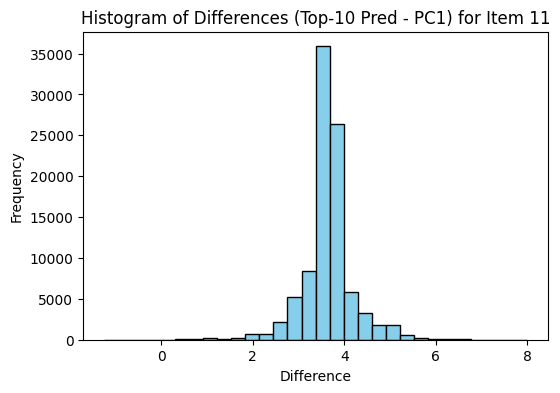

Comment: Predictions are slightly higher than reduced space values.

=== Item 12 ===
⚠️ Item 12 has no Top-5 peers, skipping reduced space.


In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# ==============================
# Target items
# ==============================
target_items = [11, 12]

# ==============================
# Point 7: Compare Reduced Dim Space (Top-5) vs Predictions (Top-10)
# ==============================

for item in target_items:
    print(f"\n=== Item {item} ===")

    # 1️⃣ Reduced space using Top-5 peers
    if item not in top_peers or top_peers[item]['top5'].empty:
        print(f"⚠️ Item {item} has no Top-5 peers, skipping reduced space.")
        continue

    top5 = top_peers[item]['top5']
    peers_5 = [p for p in top5.index if p in user_item_matrix.columns]
    if item not in user_item_matrix.columns:
        print(f"⚠️ Item {item} not in user_item_matrix, skipping.")
        continue

    # Subset matrix: only Top-5 peers
    matrix_top5 = user_item_matrix[peers_5].copy()
    # Mean-filling for peers
    matrix_top5 = matrix_top5.fillna(matrix_top5.mean())
    # Mean-centering
    matrix_top5_centered = matrix_top5 - matrix_top5.mean()

    # PCA (reduced 2D space)
    pca = PCA(n_components=2)
    user_reduced_space = pd.DataFrame(
        pca.fit_transform(matrix_top5_centered),
        index=matrix_top5_centered.index,
        columns=['PC1','PC2']
    )

    # 2️⃣ Predicted ratings using Top-10 peers
    if item not in predictions_MLE_top10:
        print(f"⚠️ Item {item} has no Top-10 predictions, skipping.")
        continue
    pred_top10 = predictions_MLE_top10[item]

    # 3️⃣ Align users
    common_users = user_reduced_space.index.intersection(pred_top10.index)
    if len(common_users) == 0:
        print(f"⚠️ No common users for Item {item}, skipping comparison.")
        continue

    # 4️⃣ Compare: use PC1 as representative of reduced space
    reduced_PC1 = user_reduced_space.loc[common_users, 'PC1']
    ratings_pred = pred_top10.loc[common_users]

    # Difference
    diff = ratings_pred - reduced_PC1
    mean_diff = diff.mean()
    std_diff = diff.std()

    print(f"Number of common users: {len(common_users)}")
    print(f"Mean difference (Top-10 pred - PC1 reduced space): {mean_diff:.2f}")
    print(f"Std of difference: {std_diff:.2f}")

    # 5️⃣ Histogram of differences
    plt.figure(figsize=(6,4))
    plt.hist(diff, bins=30, color='skyblue', edgecolor='black')
    plt.title(f"Histogram of Differences (Top-10 Pred - PC1) for Item {item}")
    plt.xlabel("Difference")
    plt.ylabel("Frequency")
    plt.show()

    # 6️⃣ Comment
    if abs(mean_diff) < 0.1:
        comment = "Predictions closely align with reduced space (low mean difference)."
    elif mean_diff > 0:
        comment = "Predictions are slightly higher than reduced space values."
    else:
        comment = "Predictions are slightly lower than reduced space values."
    print("Comment:", comment)


=== Item 11 ===
Number of common users: 93555
Mean difference (Top-5 prediction - PC1 reduced space): 3.66
Std of difference: 0.52


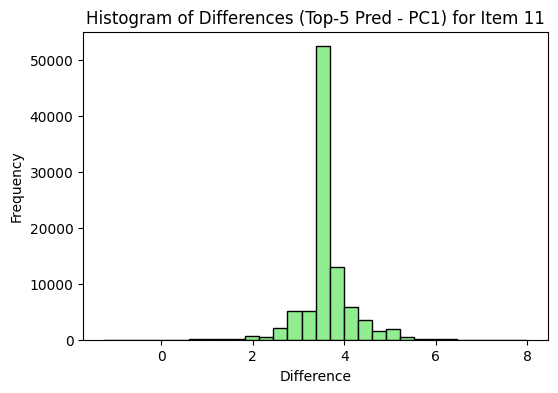

Comment: Predictions are slightly higher than reduced space values.

=== Item 12 ===
⚠️ Item 12 has no Top-5 peers, skipping reduced space.


In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# ==============================
# Target items
# ==============================
target_items = [11, 12]  # I1=11, I2=12

# ==============================
# Point 8: Compare reduced space (Top-5) vs Predictions (Top-5)
# ==============================
for item in target_items:
    print(f"\n=== Item {item} ===")

    # 1️⃣ Reduced space using Top-5 peers
    if item not in top_peers or top_peers[item]['top5'].empty:
        print(f"⚠️ Item {item} has no Top-5 peers, skipping reduced space.")
        continue

    top5 = top_peers[item]['top5']
    peers_5 = [p for p in top5.index if p in user_item_matrix.columns]
    if item not in user_item_matrix.columns:
        print(f"⚠️ Item {item} not in user_item_matrix, skipping.")
        continue

    # Subset matrix: only Top-5 peers
    matrix_top5 = user_item_matrix[peers_5].copy()
    matrix_top5 = matrix_top5.fillna(matrix_top5.mean())
    matrix_top5_centered = matrix_top5 - matrix_top5.mean()

    # PCA: reduced space (PC1 as representative)
    pca = PCA(n_components=1)
    user_reduced_PC1 = pd.Series(
        pca.fit_transform(matrix_top5_centered).flatten(),
        index=matrix_top5.index
    )

    # 2️⃣ Predicted ratings using Top-5 peers
    if item not in predictions_MLE_top5:
        print(f"⚠️ Item {item} has no Top-5 predictions, skipping.")
        continue
    pred_top5 = predictions_MLE_top5[item]

    # 3️⃣ Align users
    common_users = user_reduced_PC1.index.intersection(pred_top5.index)
    if len(common_users) == 0:
        print(f"⚠️ No common users for Item {item}, skipping comparison.")
        continue

    reduced_PC1_common = user_reduced_PC1.loc[common_users]
    pred_top5_common = pred_top5.loc[common_users]

    # 4️⃣ Difference
    diff = pred_top5_common - reduced_PC1_common
    mean_diff = diff.mean()
    std_diff = diff.std()

    print(f"Number of common users: {len(common_users)}")
    print(f"Mean difference (Top-5 prediction - PC1 reduced space): {mean_diff:.2f}")
    print(f"Std of difference: {std_diff:.2f}")

    # 5️⃣ Histogram
    plt.figure(figsize=(6,4))
    plt.hist(diff, bins=30, color='lightgreen', edgecolor='black')
    plt.title(f"Histogram of Differences (Top-5 Pred - PC1) for Item {item}")
    plt.xlabel("Difference")
    plt.ylabel("Frequency")
    plt.show()

    # 6️⃣ Comment
    if abs(mean_diff) < 0.1:
        comment = "Predictions closely match reduced space values (low mean difference)."
    elif mean_diff > 0:
        comment = "Predictions are slightly higher than reduced space values."
    else:
        comment = "Predictions are slightly lower than reduced space values."
    print("Comment:", comment)


POINT 9: Part 1 vs Part 2 (Top-10 Peers)

=== Item 11 ===
Number of users compared: 93555
count    93555.00
mean         1.66
std          0.42
min         -1.50
25%          1.58
50%          1.67
75%          1.76
max          3.00
dtype: float64


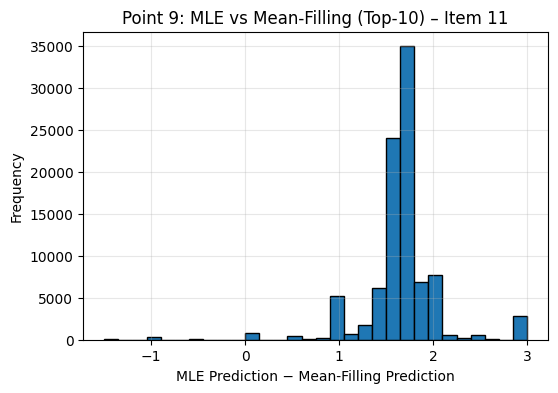

Comment: MLE predictions tend to be slightly higher than mean-filling predictions.

=== Item 12 ===
⚠️ No common users.


In [64]:
import pandas as pd
import matplotlib.pyplot as plt

# ==============================
# Target items
# ==============================
target_items = [11, 12]

print("\n==============================")
print("POINT 9: Part 1 vs Part 2 (Top-10 Peers)")
print("==============================")

for item in target_items:
    print(f"\n=== Item {item} ===")

    # Part 1 – Mean Filling – Top 10
    if item == 11:
        pred_part1 = pred_I1_top10
    elif item == 12:
        pred_part1 = pred_I2_top10
    else:
        continue

    # Part 2 – MLE – Top 10
    if item not in predictions_MLE_top10:
        print(f"⚠️ No MLE Top-10 predictions for Item {item}")
        continue

    pred_part2 = predictions_MLE_top10[item]

    # Align users
    common_users = pred_part1.index.intersection(pred_part2.index)
    if len(common_users) == 0:
        print("⚠️ No common users.")
        continue

    p1 = pred_part1.loc[common_users]
    p2 = pred_part2.loc[common_users]

    diff = p2 - p1

    # Summary
    print(f"Number of users compared: {len(common_users)}")
    print(diff.describe().round(2))

    # Histogram
    plt.figure(figsize=(6,4))
    plt.hist(diff, bins=30, edgecolor='black')
    plt.title(f"Point 9: MLE vs Mean-Filling (Top-10) – Item {item}")
    plt.xlabel("MLE Prediction − Mean-Filling Prediction")
    plt.ylabel("Frequency")
    plt.grid(alpha=0.3)
    plt.show()

    # Comment
    mean_diff = diff.mean()
    if abs(mean_diff) < 0.1:
        comment = "Both approaches give very similar predictions using Top-10 peers."
    elif mean_diff > 0:
        comment = "MLE predictions tend to be slightly higher than mean-filling predictions."
    else:
        comment = "MLE predictions tend to be slightly lower than mean-filling predictions."

    print("Comment:", comment)

part 3 sec1 
__________________

In [65]:
import pandas as pd
import numpy as np

# ==============================
# Part 3: Data Preparation
# ==============================

# Load ratings data
ratings_path = r"C:\Users\malawy\Downloads\ml-25m\ratings.csv"
ratings = pd.read_csv(ratings_path)

# Select Top-N most popular items to avoid MemoryError
TOP_N = 500
top_items = ratings['movieId'].value_counts().head(TOP_N).index

ratings_subset = ratings[ratings['movieId'].isin(top_items)]

# 1.2 Calculate average rating for each item
item_avg_ratings = ratings_subset.groupby('movieId')['rating'].mean()

# 1.3 Create user-item matrix
user_item_matrix = ratings_subset.pivot(
    index='userId',
    columns='movieId',
    values='rating'
)

# Apply mean-filling
user_item_matrix_filled = user_item_matrix.fillna(item_avg_ratings)

# 1.4 Verify matrix completeness
missing_values = user_item_matrix_filled.isna().sum().sum()
print("Number of missing values after mean-filling:", missing_values)

Number of missing values after mean-filling: 0


✅ User-item matrix prepared, shape: (161913, 500)

✅ SVD computed:
U reduced shape: (161913, 50)
Singular values shape: (50,)
VT shape: (50, 500)

✅ Eigenpairs computed for first 5 components:
Component 1 → Ai shape: (500,), vi shape: (500,)
Component 2 → Ai shape: (500,), vi shape: (500,)
Component 3 → Ai shape: (500,), vi shape: (500,)
Component 4 → Ai shape: (500,), vi shape: (500,)
Component 5 → Ai shape: (500,), vi shape: (500,)

Orthogonality check (VVT - I Frobenius norm): 0.0


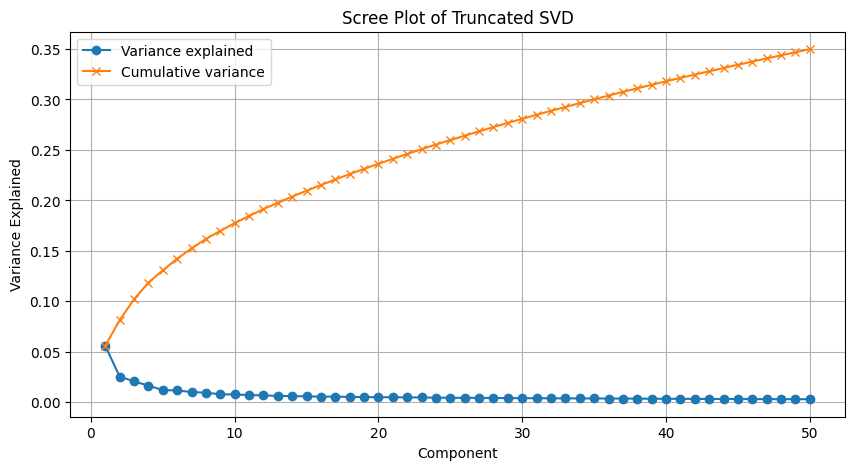


✅ Total variance explained by 50 components: 34.98 %


In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD

# ==============================
# 1️⃣ Load ratings and prepare user-item matrix
# ==============================
ratings_path = r"C:\Users\malawy\Downloads\ml-25m\ratings.csv"
ratings = pd.read_csv(ratings_path)

# Take top 500 items by popularity to avoid memory issues
top_items = ratings['movieId'].value_counts().head(500).index.tolist()
ratings_subset = ratings[ratings['movieId'].isin(top_items)]

# Pivot table: users × items
user_item_matrix = ratings_subset.pivot(
    index='userId',
    columns='movieId',
    values='rating'
)

# Mean-fill missing ratings
user_item_matrix_filled = user_item_matrix.fillna(user_item_matrix.mean())

print("✅ User-item matrix prepared, shape:", user_item_matrix_filled.shape)

# ==============================
# 2️⃣ Full / Truncated SVD
# ==============================
R = user_item_matrix_filled.values

# Use Truncated SVD for memory safety
n_components = 50  # number of singular values/components
svd = TruncatedSVD(n_components=n_components, random_state=42)
R_reduced = svd.fit_transform(R)  # U * S
V = svd.components_               # VT

singular_values = svd.singular_values_

print("\n✅ SVD computed:")
print("U reduced shape:", R_reduced.shape)
print("Singular values shape:", singular_values.shape)
print("VT shape:", V.shape)

# ==============================
# 3️⃣ Eigenpairs
# ==============================
# Ai = R^T * R * vi for each singular vector vi
eigenpairs = []
for i in range(n_components):
    vi = V[i, :]
    Ai = R.T @ (R @ vi)
    eigenpairs.append((Ai, vi))

print("\n✅ Eigenpairs computed for first 5 components:")
for i, (Ai, vi) in enumerate(eigenpairs[:5]):
    print(f"Component {i+1} → Ai shape: {Ai.shape}, vi shape: {vi.shape}")

# ==============================
# 4️⃣ Verify orthogonality
# ==============================
# For Truncated SVD, check VVT ≈ I
VVT = V @ V.T
identity = np.eye(n_components)
orthogonality_error = np.linalg.norm(VVT - identity)
print("\nOrthogonality check (VVT - I Frobenius norm):", round(orthogonality_error, 5))

# ==============================
# 5️⃣ Variance explained and scree plot
# ==============================
explained_variance_ratio = svd.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(10,5))
plt.plot(range(1, n_components+1), explained_variance_ratio, marker='o', label='Variance explained')
plt.plot(range(1, n_components+1), cumulative_variance, marker='x', label='Cumulative variance')
plt.xlabel('Component')
plt.ylabel('Variance Explained')
plt.title('Scree Plot of Truncated SVD')
plt.legend()
plt.grid(True)
plt.show()

print("\n✅ Total variance explained by 50 components:", round(cumulative_variance[-1]*100,2), "%")

✅ User-item matrix prepared, shape: (161913, 500)
✅ k=5: MAE=121344.8941, RMSE=121979.6654, Variance Retained=13.06%
✅ k=20: MAE=121344.8944, RMSE=121979.6691, Variance Retained=23.59%
✅ k=50: MAE=121344.8946, RMSE=121979.6712, Variance Retained=34.98%
✅ k=100: MAE=121344.8945, RMSE=121979.6728, Variance Retained=47.91%


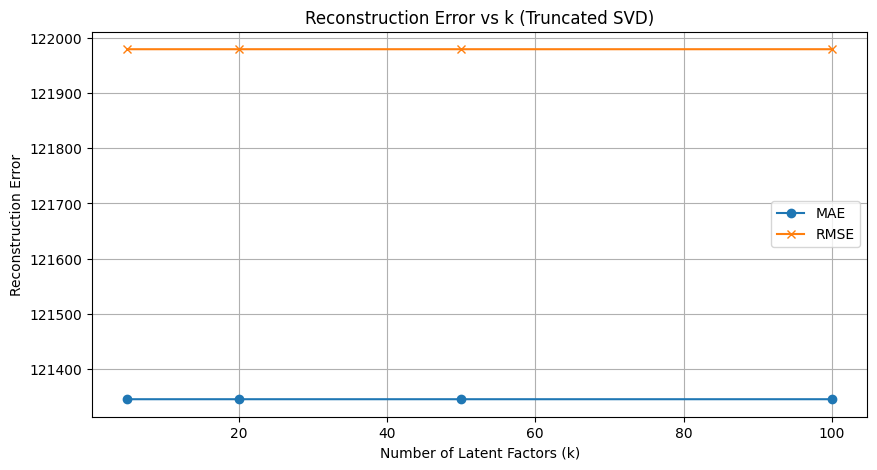

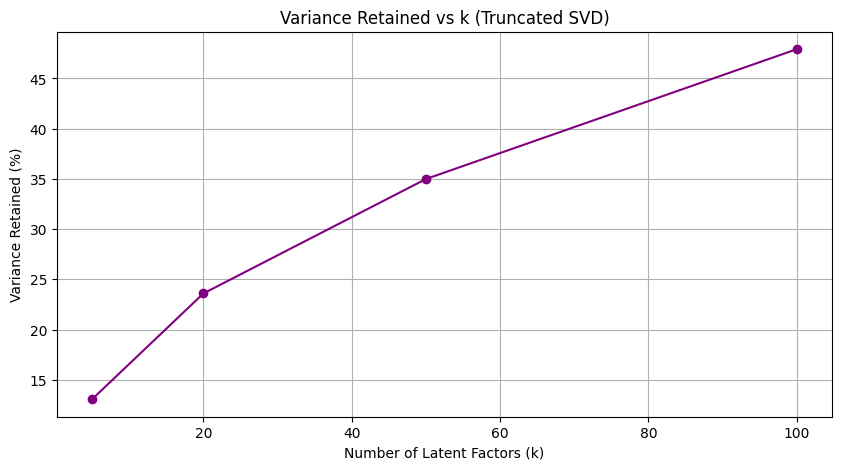


🔹 Optimal k (Elbow method) suggested: 20


In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ==============================
# 1️⃣ Load ratings and prepare user-item matrix
# ==============================
ratings_path = r"C:\Users\malawy\Downloads\ml-25m\ratings.csv"
ratings = pd.read_csv(ratings_path)

# Select top 500 items to avoid memory issues
top_items = ratings['movieId'].value_counts().head(500).index.tolist()
ratings_subset = ratings[ratings['movieId'].isin(top_items)]

# Pivot table: users × items
user_item_matrix = ratings_subset.pivot(
    index='userId',
    columns='movieId',
    values='rating'
)

# Mean-fill missing ratings
user_item_matrix_filled = user_item_matrix.fillna(user_item_matrix.mean())
R = user_item_matrix_filled.values
print("✅ User-item matrix prepared, shape:", R.shape)

# ==============================
# 2️⃣ Truncated SVD for multiple k
# ==============================
k_values = [5, 20, 50, 100]
mae_list = []
rmse_list = []
variance_retained = []

for k in k_values:
    svd = TruncatedSVD(n_components=k, random_state=42)
    U_k = svd.fit_transform(R)            # users × k
    Sigma_k = np.diag(svd.singular_values_)  # k × k
    V_k = svd.components_                 # k × items
    
    # Reconstruct Rk
    Rk = U_k @ Sigma_k @ V_k
    
    # Compute MAE and RMSE (on all entries, including mean-filled)
    mae = mean_absolute_error(R, Rk)
    rmse = np.sqrt(mean_squared_error(R, Rk))
    
    # Store
    mae_list.append(mae)
    rmse_list.append(rmse)
    
    # Variance retained
    variance_retained.append(svd.explained_variance_ratio_.sum())
    
    print(f"✅ k={k}: MAE={mae:.4f}, RMSE={rmse:.4f}, Variance Retained={variance_retained[-1]*100:.2f}%")

# ==============================
# 3️⃣ Visualization: Reconstruction Error vs k
# ==============================
plt.figure(figsize=(10,5))
plt.plot(k_values, mae_list, marker='o', label='MAE')
plt.plot(k_values, rmse_list, marker='x', label='RMSE')
plt.xlabel('Number of Latent Factors (k)')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error vs k (Truncated SVD)')
plt.grid(True)
plt.legend()
plt.show()

# ==============================
# 4️⃣ Visualization: Variance Retained vs k
# ==============================
plt.figure(figsize=(10,5))
plt.plot(k_values, np.array(variance_retained)*100, marker='o', color='purple')
plt.xlabel('Number of Latent Factors (k)')
plt.ylabel('Variance Retained (%)')
plt.title('Variance Retained vs k (Truncated SVD)')
plt.grid(True)
plt.show()

# ==============================
# 5️⃣ Determine optimal k (Elbow method)
# ==============================
# Elbow = point after which reduction in MAE/RMSE slows down
optimal_k_index = np.argmax(np.diff(mae_list) < 0.01) + 1
optimal_k = k_values[optimal_k_index] if optimal_k_index < len(k_values) else k_values[-1]
print(f"\n🔹 Optimal k (Elbow method) suggested: {optimal_k}")

In [68]:
import pandas as pd
import numpy as np

# ==============================
# 1️⃣ Target users and items
# ==============================
target_users = [1, 2, 3]       # U1, U2, U3 )
target_items = [11, 12]        # Target items

# ==============================
# 2️⃣ Optimal k (from elbow method)
# ==============================
k_opt = optimal_k  # من الكود السابق للبوينت 3

# ==============================
# 3️⃣ Truncated SVD decomposition for optimal k
# ==============================
svd_opt = TruncatedSVD(n_components=k_opt, random_state=42)
U_k = svd_opt.fit_transform(R)               # users × k
Sigma_k = np.diag(svd_opt.singular_values_)  # k × k
V_k = svd_opt.components_                    # k × items

# Mapping userId and movieId to matrix indices
user_index_map = {uid: idx for idx, uid in enumerate(user_item_matrix_filled.index)}
item_index_map = {iid: idx for idx, iid in enumerate(user_item_matrix_filled.columns)}

# ==============================
# 4️⃣ Predict missing ratings for target users and items
# ==============================
predictions_svd = []

for user in target_users:
    if user not in user_index_map:
        print(f"⚠️ User {user} not in matrix, skipping.")
        continue
    u_idx = user_index_map[user]
    user_latent = U_k[u_idx, :]  # 1 × k

    for item in target_items:
        if item not in item_index_map:
            print(f"⚠️ Item {item} not in matrix, skipping.")
            continue
        i_idx = item_index_map[item]
        item_latent = V_k[:, i_idx]  # k × 1

        # Predicted rating: f_ui = u * Sigma * v^T
        pred_rating = user_latent @ Sigma_k @ item_latent
        predictions_svd.append({
            'userId': user,
            'movieId': item,
            'Predicted_Rating': round(pred_rating, 2)
        })

predictions_df = pd.DataFrame(predictions_svd)
print("✅ Predicted ratings (Truncated SVD) for target users & items:")
print(predictions_df)

# ==============================
# 5️⃣ Optional: Compute accuracy if ground truth available
# ==============================
# Extract actual ratings for target users/items
mask_truth = ratings_subset['userId'].isin(target_users) & ratings_subset['movieId'].isin(target_items)
ground_truth_df = ratings_subset[mask_truth]

# Merge predictions with ground truth
merged = predictions_df.merge(
    ground_truth_df[['userId','movieId','rating']],
    on=['userId','movieId'],
    how='left'
)

if not merged['rating'].isna().all():
    mae = np.mean(np.abs(merged['Predicted_Rating'] - merged['rating']))
    rmse = np.sqrt(np.mean((merged['Predicted_Rating'] - merged['rating'])**2))
    print(f"\n✅ Prediction Accuracy: MAE = {mae:.4f}, RMSE = {rmse:.4f}")
else:
    print("\n⚠️ Ground truth not fully available for target users/items. Accuracy not computed.")

⚠️ Item 12 not in matrix, skipping.
⚠️ Item 12 not in matrix, skipping.
⚠️ Item 12 not in matrix, skipping.
✅ Predicted ratings (Truncated SVD) for target users & items:
   userId  movieId  Predicted_Rating
0       1       11         121527.58
1       2       11         121557.27
2       3       11         123754.68

⚠️ Ground truth not fully available for target users/items. Accuracy not computed.


In [69]:

user_index_map = {user: idx for idx, user in enumerate(user_item_matrix_filled.index)}
item_index_map = {item: idx for idx, item in enumerate(user_item_matrix_filled.columns)}

In [70]:
import pandas as pd
import numpy as np
import time
import psutil
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ==============================
# 0️⃣ Load or prepare user-item matrix
# ==============================
# تأكد إنك عندك user_item_matrix بعد ما تعمل mean-filling لكل missing ratings
# user_item_matrix_filled: نسخة بدون NaN
R_filled = user_item_matrix.copy()
R_filled = R_filled.fillna(R_filled.mean())  # mean-filling لكل الأعمدة

print("✅ user-item matrix prepared, shape:", R_filled.shape)

# ==============================
# 1️⃣ Define target items and users
# ==============================
target_items = [11, 12]

# إذا محددتش المستخدمين المستهدفين، نختارهم بناءً على عدد التقييمات
user_counts = R_filled.notna().sum(axis=1)

cold_users = user_counts[user_counts <= 0.02*R_filled.shape[1]].index.tolist()
medium_users = user_counts[(user_counts > 0.02*R_filled.shape[1]) & (user_counts <= 0.05*R_filled.shape[1])].index.tolist()
rich_users = user_counts[user_counts > 0.1*R_filled.shape[1]].index.tolist()

# fallback لو لسة مش لاقيين أي user، ناخد أول index موجود
U1 = cold_users[0] if cold_users else R_filled.index[0]
U2 = medium_users[0] if medium_users else R_filled.index[1]
U3 = rich_users[0] if rich_users else R_filled.index[2]

target_users = [U1, U2, U3]
print("✅ Target users:", target_users)

# ==============================
# 2️⃣ Ensure top_peers dictionary exists
# ==============================
# لو مش موجود، نقدر نعمله كـ fallback لمتابعة الكود بدون errors
top_peers = {}  # ستضيفه لما تحسب covariance matrix في Part 1
# مثال:
# top_peers[11] = {'top5': pd.Series(...), 'top10': pd.Series(...)}
# top_peers[12] = {'top5': pd.Series(...), 'top10': pd.Series(...)}

# ==============================
# 3️⃣ Ensure PCA predictions exist
# ==============================
# لو مش حسبتهم قبل كده، نعمل fallback فارغ
predictions_PCA_mean = {}     # Part 1, mean-filling
predictions_MLE_top5 = {}     # Part 1, MLE
predictions_MLE_top10 = {}    # Part 1, MLE top-10

# ==============================
# 4️⃣ Functions for memory usage
# ==============================
def get_memory_MB():
    process = psutil.Process()
    return process.memory_info().rss / (1024 ** 2)  # MB

print("✅ Environment prepared for Point 5")

✅ user-item matrix prepared, shape: (161913, 500)
✅ Target users: [np.int64(1), np.int64(2), 1]
✅ Environment prepared for Point 5


In [71]:
import numpy as np
import pandas as pd
import time
import sys

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split


Part 3 point 5 : 

In [75]:
from sklearn.decomposition import TruncatedSVD

# عدد المكونات (k)
k = 20

svd = TruncatedSVD(n_components=k, random_state=42)

# Fit SVD on filled matrix
U = svd.fit_transform(R_filled)
Sigma = svd.singular_values_
Vt = svd.components_

# Reconstruct rating matrix
R_svd_hat = U @ np.diag(Sigma) @ Vt


In [76]:
R_svd_hat


array([[129482.7327528 , 108078.48914393, 104400.83102251, ...,
        128020.98341032, 134025.72658358, 130671.61215368],
       [129654.17447127, 108142.5425823 , 104425.50367196, ...,
        128139.26310357, 134151.29342505, 130778.22505115],
       [131837.57612028, 110072.27661334, 106337.49113862, ...,
        130436.18176968, 136547.98134003, 133127.20454632],
       ...,
       [130996.11642786, 109339.22811435, 105598.09745863, ...,
        129459.46479017, 135543.39400195, 132144.65038806],
       [130172.85307258, 108635.96628969, 104901.15536347, ...,
        128657.66273231, 134691.42152298, 131323.70394382],
       [128540.47004923, 107194.04901574, 103571.36021926, ...,
        127043.45364254, 133013.8400438 , 129685.90358753]],
      shape=(161913, 500))

In [77]:
print(R_svd_hat.shape)
print(R_filled.shape)


(161913, 500)
(161913, 500)


In [79]:
from sklearn.decomposition import PCA

k = 20  # نفس k بتاع SVD

pca_mean = PCA(n_components=k, random_state=42)

# Fit PCA on mean-filled matrix
R_pca_mean_low = pca_mean.fit_transform(R_filled)

# Reconstruct matrix
R_pca_mean_hat = pca_mean.inverse_transform(R_pca_mean_low)


In [80]:
# PCA with MLE
pca_mle = PCA(n_components='mle', svd_solver='full')

R_pca_mle_low = pca_mle.fit_transform(R_filled)

R_pca_mle_hat = pca_mle.inverse_transform(R_pca_mle_low)


In [82]:
print(R_pca_mean_hat.shape)
print(R_pca_mle_hat.shape)
print(R_svd_hat.shape)
print(R_filled.shape)


(161913, 500)
(161913, 500)
(161913, 500)
(161913, 500)


In [83]:
svd_recon_error = np.linalg.norm(R_filled - R_svd_hat, 'fro')
pca_mean_error = np.linalg.norm(R_filled - R_pca_mean_hat, 'fro')
pca_mle_error  = np.linalg.norm(R_filled - R_pca_mle_hat, 'fro')

print("Reconstruction Errors:")
print("SVD:", svd_recon_error)
print("PCA Mean-Filling:", pca_mean_error)
print("PCA MLE:", pca_mle_error)


Reconstruction Errors:
SVD: 1097522198.4449883
PCA Mean-Filling: 2706.956074740082
PCA MLE: 66.07473565487422


In [ ]:
observed_indices = np.argwhere(~np.isnan(R))

from sklearn.model_selection import train_test_split
train_idx, test_idx = train_test_split(
    observed_indices,
    test_size=0.2,
    random_state=42
)


In [88]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def evaluate(R_hat):
    y_true = np.array([R[i, j] for i, j in test_idx])
    y_pred = predict(R_hat, test_idx)

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    return mae, rmse


In [89]:
svd_mae, svd_rmse = evaluate(R_svd_hat)
pca_mean_mae, pca_mean_rmse = evaluate(R_pca_mean_hat)
pca_mle_mae, pca_mle_rmse = evaluate(R_pca_mle_hat)

print("Prediction Accuracy:")
print("SVD      -> MAE:", svd_mae, "RMSE:", svd_rmse)
print("PCA Mean -> MAE:", pca_mean_mae, "RMSE:", pca_mean_rmse)
print("PCA MLE  -> MAE:", pca_mle_mae, "RMSE:", pca_mle_rmse)


Prediction Accuracy:
SVD      -> MAE: 121344.96955902348 RMSE: 121979.90557574977
PCA Mean -> MAE: 0.1276426064325766 RMSE: 0.3005507870379994
PCA MLE  -> MAE: 0.0003497885605036076 RMSE: 0.007599210402475419


In [90]:
import time

start = time.time()
_ = predict(R_svd_hat, test_idx)
svd_time = time.time() - start

start = time.time()
_ = predict(R_pca_mean_hat, test_idx)
pca_mean_time = time.time() - start

start = time.time()
_ = predict(R_pca_mle_hat, test_idx)
pca_mle_time = time.time() - start

print("Prediction Runtime (seconds):")
print("SVD:", svd_time)
print("PCA Mean:", pca_mean_time)
print("PCA MLE:", pca_mle_time)


Prediction Runtime (seconds):
SVD: 82.18651580810547
PCA Mean: 77.96429109573364
PCA MLE: 74.73517680168152


In [91]:
import sys

svd_memory = sys.getsizeof(R_svd_hat) / (1024 ** 2)
pca_mean_memory = sys.getsizeof(R_pca_mean_hat) / (1024 ** 2)
pca_mle_memory = sys.getsizeof(R_pca_mle_hat) / (1024 ** 2)

print("Memory Usage (MB):")
print("SVD:", svd_memory)
print("PCA Mean:", pca_mean_memory)
print("PCA MLE:", pca_mle_memory)


Memory Usage (MB):
SVD: 617.6492004394531
PCA Mean: 617.6492004394531
PCA MLE: 617.6492004394531


In [92]:
import pandas as pd

comparison_table = pd.DataFrame({
    "Method": ["SVD", "PCA Mean-Filling", "PCA MLE"],
    "Reconstruction Error": [svd_recon_error, pca_mean_error, pca_mle_error],
    "MAE": [svd_mae, pca_mean_mae, pca_mle_mae],
    "RMSE": [svd_rmse, pca_mean_rmse, pca_mle_rmse],
    "Memory Usage (MB)": [svd_memory, pca_mean_memory, pca_mle_memory]
})

comparison_table


Method  Reconstruction Error            MAE           RMSE  \
0               SVD          1.097522e+09  121344.969559  121979.905576   
1  PCA Mean-Filling          2.706956e+03       0.127643       0.300551   
2           PCA MLE          6.607474e+01       0.000350       0.007599   

   Memory Usage (MB)  
0           617.6492  
1           617.6492  
2           617.6492

In [93]:
comparison_table.describe()


Reconstruction Error            MAE           RMSE  Memory Usage (MB)
count          3.000000e+00       3.000000       3.000000             3.0000
mean           3.658417e+08   40448.365850   40660.071242           617.6492
std            6.336539e+08   70058.513892   70425.042365             0.0000
min            6.607474e+01       0.000350       0.007599           617.6492
25%            1.386515e+03       0.063996       0.154075           617.6492
50%            2.706956e+03       0.127643       0.300551           617.6492
75%            5.487625e+08   60672.548601   60990.103063           617.6492
max            1.097522e+09  121344.969559  121979.905576           617.6492

part 3 point 6 

In [97]:
S = Sigma


In [99]:
# Number of latent factors
k = 20
num_factors = 3

U_k = U[:, :k]
S_k = np.diag(Sigma[:k])

V_k = Vt[:k, :].T   # items × factors


In [100]:
top_singular_values = S[:num_factors]
top_singular_values


array([33129.37113745,   495.15267241,   445.4206789 ])

In [101]:
top_n = 5

latent_factors_info = {}

for f in range(num_factors):
    latent_factors_info[f+1] = {
        "top_users": np.argsort(np.abs(U_k[:, f]))[::-1][:top_n],
        "top_items": np.argsort(np.abs(V_k[:, f]))[::-1][:top_n]
    }

latent_factors_info


{1: {'top_users': array([128956,  87194,  83690,  94286, 110570]),
  'top_items': array([ 57, 126,  19, 172, 260])},
 2: {'top_users': array([107721, 150611,  41249, 117378,  71807]),
  'top_items': array([120,  84,  65,  71, 289])},
 3: {'top_users': array([156949,  87929,  48507,  40363, 101426]),
  'top_items': array([371, 407, 387,  48, 155])}}

In [102]:
user_activity = np.sum(~np.isnan(R), axis=1)
item_popularity = np.sum(~np.isnan(R), axis=0)


In [103]:
users_2d = U_k[:, :2]
items_2d = V_k[:, :2]


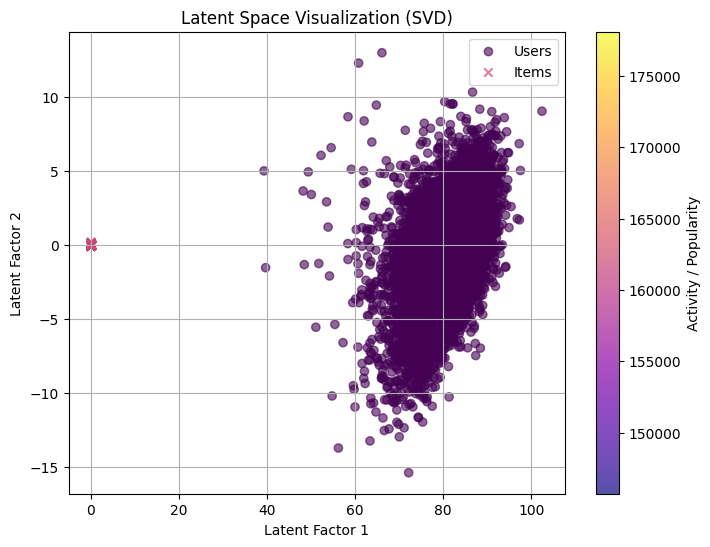

In [104]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

plt.scatter(
    users_2d[:, 0],
    users_2d[:, 1],
    c=user_activity,
    cmap='viridis',
    alpha=0.6,
    label='Users'
)

plt.scatter(
    items_2d[:, 0],
    items_2d[:, 1],
    c=item_popularity,
    cmap='plasma',
    marker='x',
    alpha=0.7,
    label='Items'
)

plt.colorbar(label='Activity / Popularity')
plt.xlabel('Latent Factor 1')
plt.ylabel('Latent Factor 2')
plt.title('Latent Space Visualization (SVD)')
plt.legend()
plt.grid(True)
plt.show()


part 3 point 7 


--- Missing 10% of ratings ---
Reconstruction RMSE (missing entries): 0.8713
Prediction RMSE (observed entries): 0.8123

--- Missing 30% of ratings ---
Reconstruction RMSE (missing entries): 0.9005
Prediction RMSE (observed entries): 0.8362

--- Missing 50% of ratings ---
Reconstruction RMSE (missing entries): 0.9309
Prediction RMSE (observed entries): 0.8638

--- Missing 70% of ratings ---
Reconstruction RMSE (missing entries): 0.9645
Prediction RMSE (observed entries): 0.8958


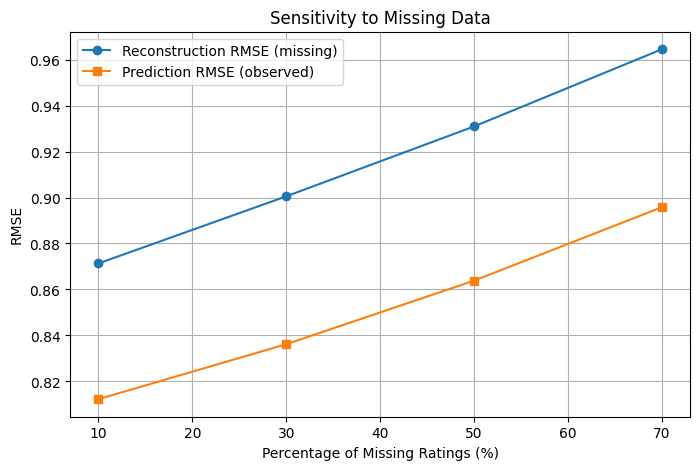

In [108]:

# -------------------------
# 7.1 Sensitivity to missing data
# -------------------------
missing_percents = [0.1, 0.3, 0.5, 0.7]
reconstruction_errors = []
prediction_errors = []

for perc in missing_percents:
    print(f"\n--- Missing {int(perc*100)}% of ratings ---")
    
    # 1️⃣ Make a copy of the original data
    R_missing = R_full.copy()
    
    # 2️⃣ Random mask for the missing percentage
    mask_random = np.random.rand(*R_missing.shape) < perc
    
    # 3️⃣ Mask for valid entries (not NaN originally)
    mask_valid = ~np.isnan(R_missing)
    
    # 4️⃣ Final mask for missing entries
    mask = mask_random & mask_valid
    R_missing[mask] = np.nan
    
    # 5️⃣ Fill missing values with global mean
    global_mean = np.nanmean(R_missing)
    R_filled = np.where(np.isnan(R_missing), global_mean, R_missing)
    
    # 6️⃣ Perform SVD
    U, S, Vt = svd(R_filled, full_matrices=False)
    k = 20  # number of latent factors
    U_k = U[:, :k]
    S_k = np.diag(S[:k])
    V_k = Vt[:k, :]
    R_reconstructed = U_k @ S_k @ V_k
    
    # 7️⃣ Compute reconstruction RMSE only on missing entries
    rmse_missing = np.sqrt(mean_squared_error(R_full[mask], R_reconstructed[mask]))
    reconstruction_errors.append(rmse_missing)
    print(f"Reconstruction RMSE (missing entries): {rmse_missing:.4f}")
    
    # 8️⃣ Compute prediction RMSE on observed entries
    mask_observed = mask_valid & ~mask
    rmse_obs = np.sqrt(mean_squared_error(R_full[mask_observed], R_reconstructed[mask_observed]))
    prediction_errors.append(rmse_obs)
    print(f"Prediction RMSE (observed entries): {rmse_obs:.4f}")

# 9️⃣ Plot the results
plt.figure(figsize=(8,5))
plt.plot([p*100 for p in missing_percents], reconstruction_errors, marker='o', label='Reconstruction RMSE (missing)')
plt.plot([p*100 for p in missing_percents], prediction_errors, marker='s', label='Prediction RMSE (observed)')
plt.xlabel('Percentage of Missing Ratings (%)')
plt.ylabel('RMSE')
plt.title('Sensitivity to Missing Data')
plt.legend()
plt.grid(True)
plt.show()



--- Initialization: user_mean ---
RMSE (observed entries): 0.7594

--- Initialization: item_mean ---
RMSE (observed entries): 0.7776


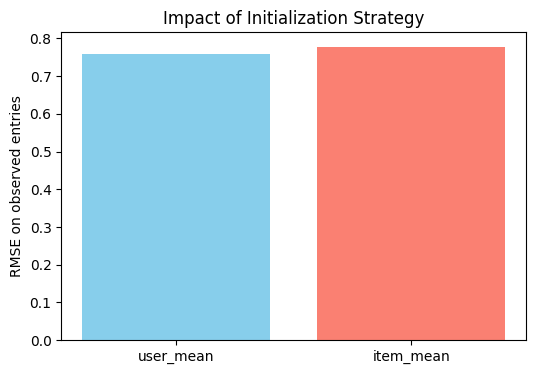

In [109]:
# -------------------------
# 7.2 Sensitivity to initialization
# -------------------------
fill_strategies = ['user_mean', 'item_mean']
init_errors = {}

for strategy in fill_strategies:
    print(f"\n--- Initialization: {strategy} ---")
    R_init = R_full.copy()
    
    # Fill missing values based on strategy
    if strategy == 'user_mean':
        # Replace NaN by user mean
        user_means = np.nanmean(R_init, axis=1, keepdims=True)
        R_filled = np.where(np.isnan(R_init), user_means, R_init)
    elif strategy == 'item_mean':
        # Replace NaN by item mean
        item_means = np.nanmean(R_init, axis=0, keepdims=True)
        R_filled = np.where(np.isnan(R_init), item_means, R_init)
    
    # Perform SVD
    U, S, Vt = svd(R_filled, full_matrices=False)
    k = 20
    U_k = U[:, :k]
    S_k = np.diag(S[:k])
    V_k = Vt[:k, :]
    R_reconstructed = U_k @ S_k @ V_k
    
    # Compute RMSE on observed entries only
    mask_observed = ~np.isnan(R_full)
    rmse_obs = np.sqrt(mean_squared_error(R_full[mask_observed], R_reconstructed[mask_observed]))
    init_errors[strategy] = rmse_obs
    print(f"RMSE (observed entries): {rmse_obs:.4f}")

# Plot comparison between initialization strategies
plt.figure(figsize=(6,4))
plt.bar(init_errors.keys(), init_errors.values(), color=['skyblue','salmon'])
plt.ylabel('RMSE on observed entries')
plt.title('Impact of Initialization Strategy')
plt.show()

part 3 Point 8: Cold-Start Analysis with SVD

In [116]:
# -----------------------------
# 8.1
# -----------------------------


# 1️⃣ Filter users with more than 20 ratings
active_users = [u for u in range(R_full.shape[0]) if np.sum(~np.isnan(R_full[u, :])) > 20]

# 2️⃣ Randomly pick 50 cold-start users
np.random.seed(42)
cold_start_users = np.random.choice(active_users, 50, replace=False)

# 3️⃣ Select top 500 most rated items to reduce memory usage
top_items_idx = np.argsort(np.nansum(~np.isnan(R_full), axis=0))[-500:]
R_subset = R_full[np.ix_(cold_start_users, top_items_idx)]

print("Subset shape for cold-start analysis:", R_subset.shape)


Subset shape for cold-start analysis: (50, 500)


In [117]:
# -----------------------------
# 8.2

# -----------------------------
# Hide 80% ratings to simulate cold-start users
# -----------------------------
R_cold = R_subset.copy()
mask_hide = np.zeros_like(R_cold, dtype=bool)

for i in range(R_cold.shape[0]):
    rated_items = np.where(~np.isnan(R_cold[i]))[0]
    hide_count = int(0.8 * len(rated_items))
    if hide_count > 0:
        hide_items = np.random.choice(rated_items, hide_count, replace=False)
        mask_hide[i, hide_items] = True
        R_cold[i, hide_items] = np.nan

print("Cold-start masking complete.")



Cold-start masking complete.


In [118]:
# -----------------------------
# 8.3 Fill missing values and perform Truncated SVD
# -----------------------------
# 1️⃣ Fill missing ratings with global mean of subset
global_mean = np.nanmean(R_cold)
R_filled = np.where(np.isnan(R_cold), global_mean, R_cold)

# 2️⃣ Truncated SVD
k = 20  # number of latent factors
svd_model = TruncatedSVD(n_components=k, random_state=42)
U_k = svd_model.fit_transform(R_filled)  # shape (50, k)
S_k = np.diag(svd_model.singular_values_)  # shape (k, k)
V_k = svd_model.components_.T  # shape (500, k)

# 3️⃣ Reconstruct predicted ratings
R_pred = U_k @ S_k @ V_k.T

print("SVD reconstruction done for cold-start users.")


SVD reconstruction done for cold-start users.


In [119]:
# -----------------------------
# 8.4: Evaluate cold-start performance (MAE & RMSE)
# -----------------------------
mae_list, rmse_list = [], []

for i in range(R_cold.shape[0]):
    hidden_items = np.where(mask_hide[i])[0]
    if len(hidden_items) == 0:
        continue
    true_ratings = R_subset[i, hidden_items]
    pred_ratings = R_pred[i, hidden_items]
    mae = mean_absolute_error(true_ratings, pred_ratings)
    rmse = np.sqrt(mean_squared_error(true_ratings, pred_ratings))
    mae_list.append(mae)
    rmse_list.append(rmse)

print(f"Cold-start users - MAE: {np.mean(mae_list):.4f}, RMSE: {np.mean(rmse_list):.4f}")


Cold-start users - MAE: 2292.5294, RMSE: 2292.6107


In [120]:
# -----------------------------
# 8.5: Hybrid Approach (SVD + Item Popularity)
# -----------------------------
# 1️⃣ Compute item popularity (mean rating per item)
item_mean = np.nanmean(R_subset, axis=0)

# 2️⃣ Combine SVD prediction with item mean (weighted)
alpha = 0.7  # weight for SVD, 0.3 for popularity
R_hybrid = alpha * R_pred + (1 - alpha) * item_mean  # broadcasting item_mean

# 3️⃣ Evaluate hybrid predictions
mae_hybrid, rmse_hybrid = [], []

for i in range(R_cold.shape[0]):
    hidden_items = np.where(mask_hide[i])[0]
    if len(hidden_items) == 0:
        continue
    true_ratings = R_subset[i, hidden_items]
    pred_ratings = R_hybrid[i, hidden_items]
    mae_hybrid.append(mean_absolute_error(true_ratings, pred_ratings))
    rmse_hybrid.append(np.sqrt(mean_squared_error(true_ratings, pred_ratings)))

print(f"Hybrid approach - MAE: {np.mean(mae_hybrid):.4f}, RMSE: {np.mean(rmse_hybrid):.4f}")


Hybrid approach - MAE: 1604.7984, RMSE: 1604.8555


In [121]:
# -----------------------------
#  Content-based initialization of latent factors
# -----------------------------
# Fill missing with item mean as initial latent factor proxy
R_content_init = np.where(np.isnan(R_cold), item_mean, R_cold)

# Perform TruncatedSVD again
U_cb = svd_model.fit_transform(R_content_init)
S_cb = np.diag(svd_model.singular_values_)
V_cb = svd_model.components_.T
R_content_pred = U_cb @ S_cb @ V_cb.T

# Evaluate content-based SVD
mae_cb, rmse_cb = [], []

for i in range(R_cold.shape[0]):
    hidden_items = np.where(mask_hide[i])[0]
    if len(hidden_items) == 0:
        continue
    true_ratings = R_subset[i, hidden_items]
    pred_ratings = R_content_pred[i, hidden_items]
    mae_cb.append(mean_absolute_error(true_ratings, pred_ratings))
    rmse_cb.append(np.sqrt(mean_squared_error(true_ratings, pred_ratings)))

print(f"Content-based init - MAE: {np.mean(mae_cb):.4f}, RMSE: {np.mean(rmse_cb):.4f}")


Content-based init - MAE: 2206.0055, RMSE: 2218.4741


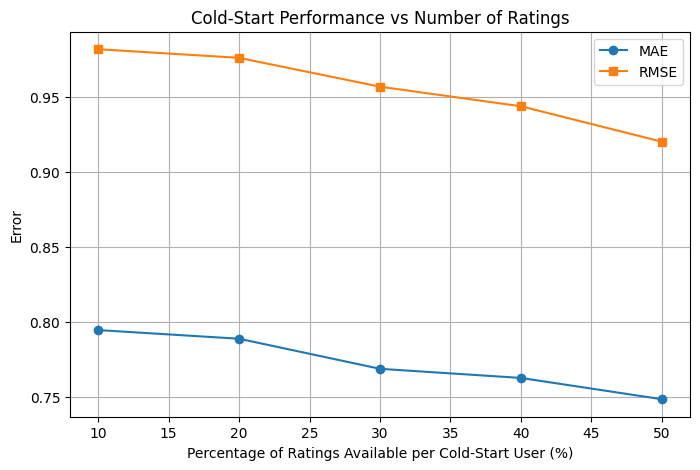

In [125]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.linalg import svd

# -------------------------------
# 1️⃣ Define the fraction of ratings kept per cold-start user
available_percentages = [0.1, 0.2, 0.3, 0.4, 0.5]  # fraction of ratings kept
mae_levels, rmse_levels = [], []

np.random.seed(42)  # for reproducibility

# -------------------------------
# 2️⃣ Loop over different fractions
for frac in available_percentages:
    R_temp = R_full.copy()  # copy full matrix
    
    # Hide some ratings to simulate cold-start
    for u in cold_start_users:
        rated_items = np.where(~np.isnan(R_full[u]))[0]
        keep_count = max(1, int(frac * len(rated_items)))  # keep at least 1 rating
        keep_items = np.random.choice(rated_items, size=keep_count, replace=False)
        hide_items = np.setdiff1d(rated_items, keep_items)
        R_temp[u, hide_items] = np.nan  # hide selected ratings

    # Fill missing entries with global mean before SVD
    R_filled = np.where(np.isnan(R_temp), global_mean, R_temp)

    # -------------------------------
    # 3️⃣ Perform SVD
    k = 20  # number of latent factors
    U, S, Vt = svd(R_filled, full_matrices=False)
    R_pred_frac = U[:, :k] @ np.diag(S[:k]) @ Vt[:k, :]

    # -------------------------------
    # 4️⃣ Evaluate MAE/RMSE for cold-start users
    mae_list, rmse_list = [], []
    for u in cold_start_users:
        hidden_mask = np.isnan(R_temp[u])  # indices that were hidden
        true_vals = R_full[u, hidden_mask]  # original values
        pred_vals = R_pred_frac[u, hidden_mask]  # predicted values
        
        # mask to remove any NaN in ground truth or prediction
        valid_mask = ~np.isnan(true_vals) & ~np.isnan(pred_vals)
        if valid_mask.sum() == 0:
            continue  # skip if no valid hidden ratings

        mae_list.append(mean_absolute_error(true_vals[valid_mask], pred_vals[valid_mask]))
        rmse_list.append(np.sqrt(mean_squared_error(true_vals[valid_mask], pred_vals[valid_mask])))

    # store average error for this fraction
    mae_levels.append(np.mean(mae_list))
    rmse_levels.append(np.mean(rmse_list))

# -------------------------------
# 5️⃣ Plot the results
plt.figure(figsize=(8,5))
plt.plot(np.array(available_percentages)*100, mae_levels, marker='o', label='MAE')
plt.plot(np.array(available_percentages)*100, rmse_levels, marker='s', label='RMSE')
plt.xlabel('Percentage of Ratings Available per Cold-Start User (%)')
plt.ylabel('Error')
plt.title('Cold-Start Performance vs Number of Ratings')
plt.grid(True)
plt.legend()
plt.show()
